# SHAP VALUES STUDY

In [2]:
!pip install plotly
!pip install boto3==1.19.12
!pip install s3fs
!pip install lightgbm
!pip install shap
!pip install catboost

In [3]:
!pip freeze > requirements.txt

#### Imports

In [4]:
# General
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os
import numpy as np
import datetime
import boto3
import s3fs
from itertools import combinations
import pickle

# Sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Models
from catboost import CatBoostClassifier, cv, Pool
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor


# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP
import shap

# Random
import random

#Warnings
import warnings
warnings.filterwarnings("ignore")

#### Paths

In [5]:
s3_resource = boto3.resource("s3")
S3_BUCKET = 'iberia-data-lake'
insert_date_ci='2024-06-14'
prefix = f'customer/nps_surveys/export_historic/insert_date_ci={insert_date_ci}/'
dir_dict = 's3://iberia-data-lake/customer/nps_surveys/nps_dictionaries'

lf_dir = 's3://ibdata-prod-ew1-s3-customer/customer/load_factor_to_s3_nps_model/'

#### Read data

In [6]:
s3_keys = [item.key for item in s3_resource.Bucket(S3_BUCKET).objects.filter(Prefix=prefix)]
preprocess_paths = [f"s3://{S3_BUCKET}/{key}" for key in s3_keys]
df_nps = pd.DataFrame()
for file in preprocess_paths:
    df = pd.read_csv(file)
    df_nps = pd.concat([df_nps, df], axis=0)
df_touchpoints = pd.read_csv(f'{dir_dict}/nps_dictionary_touchpoints.csv')
df_issues = pd.read_csv(f'{dir_dict}/nps_dictionary_issues.csv')
df_nps = df_nps.reset_index(drop=True)

In [7]:
df_touchpoints_issues = df_touchpoints.merge(df_issues[["associated_touchpoint", "issue_type_2"]],
                                             left_on = "survey_maritz_name", right_on = "associated_touchpoint", how = "left")
df_touchpoints_issues["issue_type_2"] = df_touchpoints_issues["issue_type_2"].str.lower()
df_touchpoints_issues = df_touchpoints_issues.loc[(df_touchpoints_issues["issue_type_2"].notnull())
                    & (df_touchpoints_issues["issue_type_2"] != "issuewifi")].drop(["survey_maritz_name"], axis = 1)
issues_list = [i for i in df_touchpoints_issues["issue_type_2"].unique()]

For the load_factor data I need to assume the prod role

In [8]:
sts_client = boto3.client('sts')

assumed_role = sts_client.assume_role(
    RoleArn="arn:aws:iam::320714865578:role/ibdata-prod-role-assume-customer-services-from-ibdata-aip-prod",
    RoleSessionName="test"
)

credentials = assumed_role['Credentials']

# Configura s3fs para acceder a S3 con tus credenciales
fs = s3fs.S3FileSystem(key=credentials['AccessKeyId'], secret=credentials['SecretAccessKey'], token=credentials['SessionToken'])

# Especifica la ruta de la carpeta
bucket_name = 'ibdata-prod-ew1-s3-customer'
folder_path = 'customer/load_factor_to_s3_nps_model/'

# Lista todos los archivos en la carpeta
files = fs.ls(f'{bucket_name}/{folder_path}')

# Leer y concatenar todos los archivos Parquet en un solo DataFrame
dataframes = []
for file in files:
    with fs.open(f's3://{file}') as f:
        df = pd.read_csv(f)
        dataframes.append(df)

# Concat the dfs
df_load_factor = pd.concat(dataframes, ignore_index=True)

In [9]:
df_load_factor

,flight_date_local,flight_date_utc,operating_carrier,op_flight_num,boardpoint_stn_code_actual,offpoint_stn_code_actual,haul,calc_dep_diff,punctuality,capacity_business,pax_business,capacity_premium_ec,pax_premium_ec,capacity_economy,pax_economy,departure_hour,arrival_hour,aircraft_registration_code_actual,flight_date_utc_rescheduled,op_carrier_group_ib,op_carrier,punctuality_takeoff,punctuality2
0,2023-11-14,2023-11-14,IB,3426,MAD,CDG,SH,26,OTP15,8,8,0,0,168,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-11-14,2023-11-14,IB,577,SCQ,MAD,SH,-2,NaN,6,1,0,0,132,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-11-14,2023-11-14,IB,6841,MAD,EZE,LH,3,NaN,31,31,24,24,293,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-11-14,2023-11-14,IB,6586,BOG,MAD,LH,2,NaN,31,19,28,20,293,224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-11-14,2023-11-15,IB,6314,SJO,MAD,LH,18,OTP15,19,11,0,0,269,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741451,2024-07-08,NaN,NaN,6650,LIM,MAD,LH,-2,NaN,33,29,0,0,301,287,19.000,NaN,ECOAX,2024-07-09,IB,IB,-2.000,NaN
741452,2024-07-08,NaN,NaN,6342,SAL,MAD,LH,-17,NaN,19,12,0,0,269,203,19.000,NaN,ECMUD,2024-07-09,IB,IB,-17.000,NaN
741453,2024-07-08,NaN,NaN,6118,MIA,MAD,LH,20,OTP15,31,30,24,19,293,206,21.000,NaN,ECNSC,2024-07-09,IB,IB,20.000,OTP15
741454,2024-07-08,NaN,NaN,6832,SCL,MAD,LH,-1,NaN,31,28,24,13,291,129,22.000,NaN,ECMXV,2024-07-09,IB,IB,-1.000,NaN


#### Main information analysis

Filter out null tickets

In [10]:
df_nps['date_flight_local'].min()

'2017-01-09'

In [11]:
df_nps['segment'].isna().sum()

231185

In [12]:
condition_1 = (df_nps['operating_airline_code'].isin(['IB', 'YW']))
condition_2 = ((df_nps['invitegroup_ib'] != 3) | (df_nps['invitegroup_ib'].isnull()))
condition_3 = (df_nps['invitegroup'] == 2)

df_nps_tkt = df_nps.loc[condition_1 & (condition_2 & condition_3)]

In [13]:
df_load_factor = df_load_factor.loc[(df_load_factor['operating_carrier'].isin(['IB', 'YW']))]

#### Filter out null ticket num if 2019 is not wanted

#### Cast and format date columns

In [14]:
datetime_features = ['date_flight_local', 'scheduled_departure_time_local', 'scheduled_arrival_time_local', 'real_departure_time_local',
                     'real_arrival_time_local', 'started']
columns_ext = ['tier_level', 'language_code', 'seat_no', 'volume_of_bags', 'number_of_child_in_the_booking', 'number_of_infant_in_the_booking',
              'number_of_people_in_the_booking', 'segment', 'customer_journey_origin', 'customer_journey_destination', 'number_of_flights_in_journey',
              'order_of_flight_in_journey', 'marketing_airline_code', 'overall_haul', 'weight_category', 'ff_number', 'ticket_num', 'operating_airline_code',
              'cabin_in_surveyed_flight', 'nps_category', 'nps_100', 'group_age_survey', 'gender', 'indicator_covid'] # invite_group
touchpoints = ['bkg_200_journey_preparation', 'pfl_100_checkin', 'pfl_200_security', 'pfl_300_lounge',
               'pfl_500_boarding', 'ifl_300_cabin', 'ifl_200_flight_crew_annoucements', 'ifl_600_wifi', 'ifl_500_ife',
               'ifl_400_food_drink', 'ifl_100_cabin_crew', 'arr_100_arrivals', 'con_100_connections', 'pun_100_punctuality',
               'loy_200_loyalty_programme', 'inm_400_issues_response', 'img_310_ease_contact_phone']
survey_fields = ['cla_600_wifi_t_f', 'tvl_journey_reason']
features = datetime_features + columns_ext + touchpoints + survey_fields
labels = ['promoter_binary', 'detractor_binary']
labels_multi = ['label_multiclass']

for feat in datetime_features:
    if feat in ['scheduled_departure_time_local', 'scheduled_arrival_time_local', 'real_departure_time_local', 'real_arrival_time_local']:
        df_nps_tkt[feat] = pd.to_datetime(df_nps_tkt[feat], format="%Y%m%d %H:%M:%S", errors = 'coerce')
    else:
        df_nps_tkt[feat] = pd.to_datetime(df_nps_tkt[feat], errors = 'ignore')
df_nps_tkt['time_spent_hrminsec'] = pd.to_timedelta(df_nps_tkt['time_spent_hrminsec']).dt.total_seconds()
df_nps_tkt['started_hour'] = df_nps_tkt['started'].dt.hour
df_nps_tkt['year_flight'] = df_nps_tkt['date_flight_local'].dt.year
df_nps_tkt['month_flight'] = df_nps_tkt['date_flight_local'].dt.month
df_nps_tkt['day_flight'] = df_nps_tkt['date_flight_local'].dt.day
df_nps_tkt['weekday_flight'] = df_nps_tkt['date_flight_local'].dt.weekday
df_nps_tkt['is_weekend_or_friday_flight'] = df_nps_tkt['weekday_flight'].apply(lambda x: 1 if x in [5, 6,7] else 0)
df_nps_tkt['delay_departure'] = (df_nps_tkt['real_departure_time_local'] - df_nps_tkt['scheduled_departure_time_local']).dt.total_seconds()/60
df_nps_tkt['delay_arrival'] = (df_nps_tkt['real_arrival_time_local'] - df_nps_tkt['scheduled_arrival_time_local']).dt.total_seconds()/60
datetime_features = datetime_features + ['time_spent_hrminsec', 'started_hour', 'year_flight', 'month_flight',
                                         'day_flight', 'weekday_flight', 'is_weekend_or_friday_flight']

In [15]:
df_load_factor['flight_date_local'] = pd.to_datetime(df_load_factor['flight_date_local'])

#### Filter out covid years

In [16]:
df_nps_tkt = df_nps_tkt[~df_nps_tkt['date_flight_local'].dt.year.isin([2020, 2021])]

In [17]:
df_load_factor = df_load_factor[~df_load_factor['flight_date_local'].dt.year.isin([2020, 2021])]

In [18]:
df_nps_tkt[(df_nps_tkt['date_flight_local'].dt.year==2019) & (df_nps_tkt['date_flight_local'].dt.month==1)]['delay_departure']

54        NaN
59        NaN
74        NaN
87        NaN
247       NaN
           ..
1070577   NaN
1070581   NaN
1070587   NaN
1070604   NaN
1070629   NaN
Name: delay_departure, Length: 7982, dtype: float64

#### Preprocess numerical variables

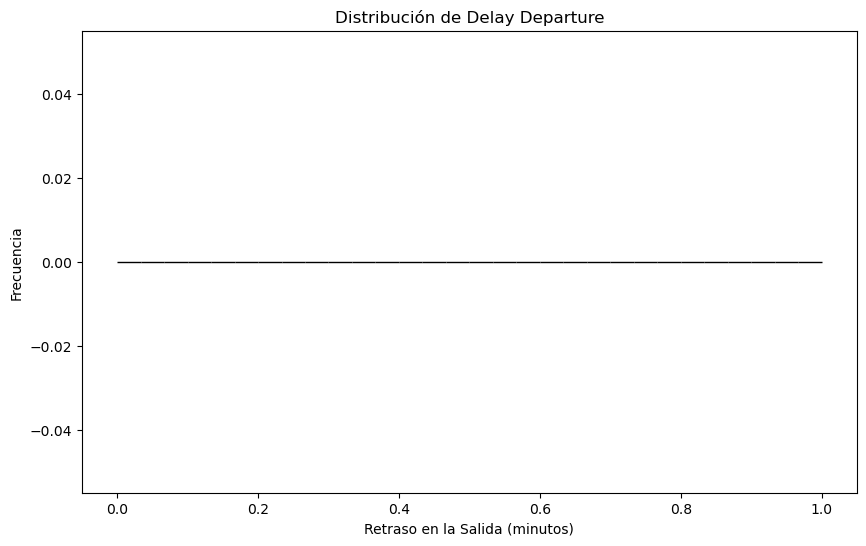

In [19]:
# Crear el gráfico de la distribución
plt.figure(figsize=(10, 6))
sns.histplot(df_nps_tkt['delay_departure'], kde=True, color="skyblue", bins=30)
plt.title('Distribución de Delay Departure')
plt.xlabel('Retraso en la Salida (minutos)')
plt.ylabel('Frecuencia')
plt.show()

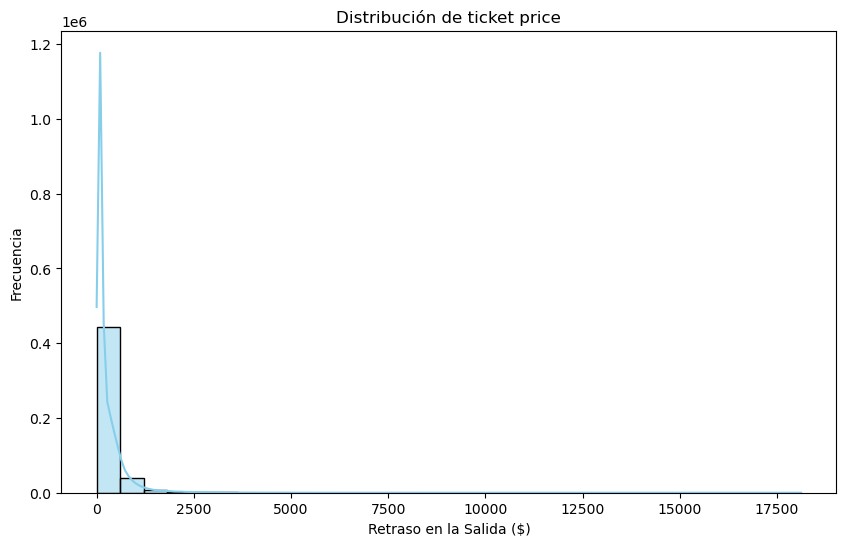

In [20]:
# Crear el gráfico de la distribución
plt.figure(figsize=(10, 6))
sns.histplot(df_nps_tkt['ticket_price'], kde=True, color="skyblue", bins=30)
plt.title('Distribución de ticket price')
plt.xlabel('Retraso en la Salida ($)')
plt.ylabel('Frecuencia')
plt.show()

#### Create otp and load_factor variables


In [21]:
df_nps_tkt['otp15_takeoff'] = (df_nps_tkt['delay'] > 15).astype(int)



In [22]:
df_load_factor.columns

Index(['flight_date_local', 'flight_date_utc', 'operating_carrier',
       'op_flight_num', 'boardpoint_stn_code_actual',
       'offpoint_stn_code_actual', 'haul', 'calc_dep_diff', 'punctuality',
       'capacity_business', 'pax_business', 'capacity_premium_ec',
       'pax_premium_ec', 'capacity_economy', 'pax_economy', 'departure_hour',
       'arrival_hour', 'aircraft_registration_code_actual',
       'flight_date_utc_rescheduled', 'op_carrier_group_ib', 'op_carrier',
       'punctuality_takeoff', 'punctuality2'],
      dtype='object')

In [23]:
df_load_factor.columns

Index(['flight_date_local', 'flight_date_utc', 'operating_carrier',
       'op_flight_num', 'boardpoint_stn_code_actual',
       'offpoint_stn_code_actual', 'haul', 'calc_dep_diff', 'punctuality',
       'capacity_business', 'pax_business', 'capacity_premium_ec',
       'pax_premium_ec', 'capacity_economy', 'pax_economy', 'departure_hour',
       'arrival_hour', 'aircraft_registration_code_actual',
       'flight_date_utc_rescheduled', 'op_carrier_group_ib', 'op_carrier',
       'punctuality_takeoff', 'punctuality2'],
      dtype='object')

In [24]:
# Asumiendo que df_load_factor es tu DataFrame y ya está definido con las columnas relevantes

# Calculando el factor de carga para cada cabina
df_load_factor['load_factor_business'] = df_load_factor['pax_business'] / df_load_factor['capacity_business']
df_load_factor['load_factor_premium_ec'] = df_load_factor['pax_premium_ec'] / df_load_factor['capacity_premium_ec']
df_load_factor['load_factor_economy'] = df_load_factor['pax_economy'] / df_load_factor['capacity_economy']

# Mostrando las nuevas columnas con los factores de carga calculados
df_load_factor[['load_factor_business', 'load_factor_premium_ec', 'load_factor_economy']].head()


,load_factor_business,load_factor_premium_ec,load_factor_economy
0,1.000,NaN,0.994
1,0.167,NaN,0.909
2,1.000,1.000,1.000
3,0.613,0.714,0.765
4,0.579,NaN,0.926


In [25]:
# Asegurarse de que 'flight_date_local' está en formato datetime
df_load_factor['flight_date_local'] = pd.to_datetime(df_load_factor['flight_date_local'])

# Filtrar solo los vuelos de 2023
df_2023 = df_load_factor[df_load_factor['flight_date_local'].dt.year == 2023]

# Extraer mes y año de 'flight_date_local'
df_2023['year_month'] = df_2023['flight_date_local'].dt.to_period('M')

# Agrupar por 'year_month' y 'haul', sumar los pax y capacidad para cada cabina
grouped = df_2023.groupby(['year_month', 'haul']).agg(
    total_pax_business=pd.NamedAgg(column='pax_business', aggfunc='sum'),
    total_capacity_business=pd.NamedAgg(column='capacity_business', aggfunc='sum'),
    total_pax_premium_ec=pd.NamedAgg(column='pax_premium_ec', aggfunc='sum'),
    total_capacity_premium_ec=pd.NamedAgg(column='capacity_premium_ec', aggfunc='sum'),
    total_pax_economy=pd.NamedAgg(column='pax_economy', aggfunc='sum'),
    total_capacity_economy=pd.NamedAgg(column='capacity_economy', aggfunc='sum')
).reset_index()

# Calcular el factor de carga para cada cabina
grouped['load_factor_business'] = grouped['total_pax_business'] / grouped['total_capacity_business']
grouped['load_factor_premium_ec'] = grouped['total_pax_premium_ec'] / grouped['total_capacity_premium_ec']
grouped['load_factor_economy'] = grouped['total_pax_economy'] / grouped['total_capacity_economy']

# Mostrando los resultados
grouped[['year_month', 'haul', 'load_factor_business', 'load_factor_premium_ec', 'load_factor_economy']]



,year_month,haul,load_factor_business,load_factor_premium_ec,load_factor_economy
0,2023-01,LH,0.869,0.819,0.849
1,2023-01,SH,0.587,NaN,0.786
2,2023-02,LH,0.885,0.797,0.866
3,2023-02,SH,0.666,NaN,0.845
4,2023-03,LH,0.912,0.832,0.874
5,2023-03,SH,0.707,NaN,0.856
6,2023-04,LH,0.906,0.849,0.882
7,2023-04,SH,0.666,0.952,0.840
8,2023-05,LH,0.937,0.873,0.872
9,2023-05,SH,0.683,0.979,0.841


In [26]:
df_nps['cabin_in_surveyed_flight'].unique()

array(['Economy', 'Business', 'Premium Economy'], dtype=object)

In [27]:
df_nps['operating_airline_code'].unique()

array(['IB', 'YW', nan], dtype=object)

In [28]:
df_nps_tkt['operating_airline_code']

0          IB
1          IB
2          IB
3          IB
4          IB
           ..
1076891    IB
1076892    IB
1076893    IB
1076894    IB
1076895    IB
Name: operating_airline_code, Length: 829994, dtype: object

In [29]:
# Crear un mapeo basado en el nombre de la cabina hacia la columna de factor de carga en df_load_factor
cabin_to_load_factor_column = {
    'Economy': 'load_factor_economy',
    'Business': 'load_factor_business',
    'Premium Economy': 'load_factor_premium_ec'
}

# Asumiendo que el DataFrame df_nps_tkt ya tiene la columna 'cabin_in_surveyed_flight'

# Paso 3: Realizar una fusión condicional

# Copia el DataFrame original para mantener la integridad de los datos
df_load_factor_renamed = df_load_factor.copy()

# Renombra las columnas manualmente
df_load_factor_renamed.columns = ['date_flight_local' if x=='flight_date_local' else 
                                  'operating_airline_code' if x=='operating_carrier' else
                                  'surveyed_flight_number' if x=='op_flight_num' else
                                  x for x in df_load_factor_renamed.columns]

# Continúa con el proceso de fusión
df_merged = pd.merge(df_nps_tkt, df_load_factor_renamed, 
                     how='left', 
                     on=['date_flight_local', 'operating_airline_code', 'surveyed_flight_number', 'haul'])

# Asigna el factor de carga correcto
df_merged['load_factor'] = df_merged.apply(lambda row: row[cabin_to_load_factor_column[row['cabin_in_surveyed_flight']]], axis=1)

# Resultado
df_final = df_merged[['date_flight_local', 'operating_airline_code', 'surveyed_flight_number', 'haul', 'cabin_in_surveyed_flight', 'load_factor']]



In [30]:
df_merged.columns

Index(['respondent_id', 'sample_id', 'surveyed_flight_number',
       'date_flight_local', 'scheduled_departure_time_local',
       'scheduled_arrival_time_local', 'tier_level', 'language_code',
       'aircraft_registration_number', 'seat_no',
       ...
       'aircraft_registration_code_actual', 'flight_date_utc_rescheduled',
       'op_carrier_group_ib', 'op_carrier', 'punctuality_takeoff',
       'punctuality2', 'load_factor_business', 'load_factor_premium_ec',
       'load_factor_economy', 'load_factor'],
      dtype='object', length=613)

In [31]:
df_nps_tkt = df_merged.copy()

In [ ]:
df_nps_tkt['haul'] = df_nps_tkt['haul'].replace('MH', 'SH')

In [32]:
df_nps_tkt[df_nps_tkt['delay']>150][['date_flight_local', 'surveyed_flight_number','delay']]

,date_flight_local,surveyed_flight_number,delay
156,2023-04-27,6454.000,172.000
200,2019-06-08,6400.000,226.000
212,2019-07-27,1331.000,256.000
295,2018-02-05,6845.000,201.000
434,2018-06-13,6827.000,510.000
...,...,...,...
834452,2019-12-20,425.000,152.000
834669,2023-09-11,6123.000,183.000
834672,2023-10-09,6454.000,156.000
834738,2023-10-26,539.000,159.000


#### Create flag promoter and detractor

In [33]:
df_nps_tkt["promoter_binary"] = df_nps_tkt["nps_category"].apply(lambda x: 1 if x == "Promoter" else 0)
df_nps_tkt["detractor_binary"] = df_nps_tkt["nps_category"].apply(lambda x: 1 if x == "Detractor" else 0)
df_nps_tkt["label_multiclass"] = df_nps_tkt["nps_category"].apply(lambda x: 1 if x == "Promoter" else (-1 if x == 'Detractor' else 0))

#### Create some features

In [34]:
def wifi_var(df):

    df["wifi_not_working"] = df["cla_600_wifi_t_f"].apply(lambda x: 1 if x in ["Could not get it to work", "No - I could not get it to work"] else 0)
    df["wifi_used_success"] = df["cla_600_wifi_t_f"].apply(lambda x: 1 if x in ["Yes", "Yes, but not enough"] else 0)
    
    return df

def group_journey_reason(df):
    
    df["tvl_journey_reason"] = df["tvl_journey_reason"].apply(lambda x: 1 if x in ["Business", "Business/work"] else 0)
    
    return df

def feature_covid_indicator(df):
    
    df.loc[df["date_flight_local"] <= "2020-03-13", "indicator_covid"] = 0
    df.loc[df["date_flight_local"] > "2020-03-13", "indicator_covid"] = 1
    
    return df

def group_residence_country(df):
    
    ESP = ["ES"]
    
    EUR = ["AT", "BE", "CH", "DE", "FR", "GB", "UX", "GR", "IL", "IT", "MA", "NL", "PT", "RU", "SE", "CZ", "DZ", 
                 "IE", "SI", "AD", "DK", "FI", "HR", "HU", "LU", "PL", "RO", "SK", "MC", "EE", "NO", "SN"]    
    
    AM_NOR = ["CA", "MX", "PR", "US"]

    LATAM = ["CR", "CU", "DO", "GT", "NI", "PA", "SV", "VE", "HN", "AR", "BR", "CL", "CO", "EC", "PE", "UY", "BO"]
    
    df.loc[df["res100_country_code_survey"].isin(ESP), "country_aggr"] = "ESP"
    df.loc[df["res100_country_code_survey"].isin(EUR), "country_aggr"] = "EUR"
    df.loc[df["res100_country_code_survey"].isin(AM_NOR), "country_aggr"] = "AM_NOR"
    df.loc[df["res100_country_code_survey"].isin(LATAM), "country_aggr"] = "LATAM"
    
    df["country_aggr"] = df["country_aggr"].fillna("Others")
    return df


def group_residence_country_custom(df):
    
    regions = {'EUROPA': ['Albania', 'AL','Andorra','AD','Armenia','AM','Austria','AT','Azerbaijan','Belarus','BY','Belgium','BE','Bosnia and Herzegovina','BA','Bulgaria','BG','Croatia','HR',
      'Cyprus','CY','Czech Republic','CZ','Denmark','DK','Estonia','EE','Faeroe Islands','FO','Finland','FI','France','FR','Georgia','GE','Germany','DE','Gibraltar','GI','Greece','GR','Greenland',
      'GL','Hungary','HU','Iceland','IS','Ireland','IE','Italy','IT','Latvia','LV','Lebanon','LB','Liechtenstein','LI','Lithuania','LT','Luxembourg','LU','Malta','MT','Moldova','MD','Monaco',
      'ME','Netherlands','NL','MK','Northern Ireland','Norway','NO','Poland','PL','Portugal','PT','MC','Romania','RO','Russia','RU','San Marino','SM','RS','Slovakia','SK','Slovenia','SI','Sweden',
      'SE','Switzerland','CH','Turkey','TR','UK (excl NI)','Ukraine','UA','GB','Vatican City','Yugoslavia'],
     'AFRICA': ['Algeria','DZ','Angola','AO','Botswana','Burkina Faso','BF','Burundi','Cameroon','CM','Cape Verde','CV','Central African Republic','Comoros','Congo',"Côte d'Ivoire",'Djibouti','DJ',
      'Egypt','EG','Equatorial Guinea','GQ','Eritrea','ER','SZ','Ethiopia','ET','French Southern Territories','Gabon','GA','GM','Ghana','GH','Guinea','Guinea-Bissau','GW','CI','Jordan','JO','Kenya',
      'KE','Liberia','LR','Libya','LY','Macedonia','Madagascar','MG','Malawi','MW','Mali','ML','Mauritania','MR','Mauritius','MU','Mayotte','YT','Morocco','MA','Mozambique','MZ','Namibia','Niger',
      'Nigeria','NG','CG','RE','Réunion','Rwanda','São Tomé and Príncipe','Senegal','SN','Seychelles','SC','Sierra Leone','SO','South Africa','ZA','SD','Sudan','Swaziland','Tanzania','TZ','The Gambia',
      'Togo','Trinidad and Tobago','TT','Tunisia','TN','Uganda','UG','Western Sahara''Zambia','Zimbabwe','ZW','Somalia','Benin'],
     'ASIA': ['Afghanistan','AF','Australia','AU','Bangladesh','Bhutan','BN','Cambodia','KH','China','CN','Cocos (Keeling) Islands','Cook Islands','East Timor','Fiji','FJ','French Polynesia','PF',
      'GU','Hong Kong','HK','India','IN','Indonesia','ID','Japan','JP','MO','Macau','Malaysia','MY','Maldives','MV','Micronesia','MN','Myanmar','MM','Nepal','NP','New Caledonia','NC','New Zealand',
      'NZ','Northern Marianas','Papua New Guinea','PG','Philippines','PH','Singapore','SG','Solomon Islands','South Korea','KR','Sri Lanka','LK','Taiwan','TW','Tajikistan','Thailand','TH','Turkmenistan',
      'TM','Uzbekistan','UZ','VU','Vanuatu','Vietnam','VN','Wallis and Futuna','Brunei','Guam'],
     'AMERICA CENTRO': ['American Samoa','Anguilla','Antigua and Barbuda','Aruba','AW','BS','Barbados','Belize','BZ','British Virgin Islands','VG','Cayman Islands','KY','Colombia','CO','Costa Rica','CR',
      'Cuba','CU','Dominica','DM','Dominican Republic','DO','El Salvador','SV','Falkland Islands','FK','Grenada','GD','Guadeloupe','GP','Guatemala','GT','Haiti','HT','Honduras','HN','Jamaica','JM',
      'Martinique','MQ','Mexico','MX','Montserrat','MS','Netherlands Antilles','Panama','PA','Puerto Rico','PR','Saint Helena','KN','Saint Lucia','Saint Vincent and the Grenadines','The Bahamas',
      'Turks and Caicos Islands','TC','US Virgin Islands','VI','Saint Kitts and Nevis'],
     'AMERICA SUR': ['Argentina','AR','Bolivia','BO','Brazil','BR','Chile','CL','Ecuador','EC','French Guiana','GF','Guyana','GY','Nicaragua','NI','Paraguay','PY','Peru','PE','Suriname','Uruguay','UY',
      'Venezuela','VE'],
     'ORIENTE MEDIO': ['Bahrain','BH','Bermuda','BM','Iran','IR','Iraq','IQ','Israel','IL','Kazakhstan','KZ','Kuwait','KW','Kyrgyzstan','KG','Oman','OM','Pakistan','PK','Qatar','QA','Saudi Arabia',
      'SA','Syria','United Arab Emirates','AE','Yemen'],
     'AMERICA NORTE': ['Canada', 'CA', 'United States', 'US'],
     'ESPAÑA': ['Spain', 'ES']}
    
    # Defining regions with corresponding country codes directly within the function
    EUROPA = regions["EUROPA"]
    AFRICA = regions["AFRICA"]
    ASIA = regions["ASIA"]
    AMERICA_CENTRO = regions["AMERICA CENTRO"]
    AMERICA_SUR = regions["AMERICA SUR"]
    ORIENTE_MEDIO = regions["ORIENTE MEDIO"]
    AMERICA_NORTE = regions["AMERICA NORTE"]
    ESPAÑA = regions["ESPAÑA"]
    
    # Assigning regions to 'country_aggr' based on the country codes
    df.loc[df["res100_country_code_survey"].isin(ESPAÑA), "country_aggr"] = "ESPAÑA"
    df.loc[df["res100_country_code_survey"].isin(EUROPA), "country_aggr"] = "EUROPA"
    df.loc[df["res100_country_code_survey"].isin(AFRICA), "country_aggr"] = "AFRICA"
    df.loc[df["res100_country_code_survey"].isin(ASIA), "country_aggr"] = "ASIA"
    df.loc[df["res100_country_code_survey"].isin(AMERICA_CENTRO), "country_aggr"] = "AMERICA CENTRO"
    df.loc[df["res100_country_code_survey"].isin(AMERICA_SUR), "country_aggr"] = "AMERICA SUR"
    df.loc[df["res100_country_code_survey"].isin(ORIENTE_MEDIO), "country_aggr"] = "ORIENTE MEDIO"
    df.loc[df["res100_country_code_survey"].isin(AMERICA_NORTE), "country_aggr"] = "AMERICA NORTE"
    
    # Defaulting to 'Others' for countries not listed
    df["country_aggr"] = df["country_aggr"].fillna("Others")
    
    return df

def issues_binary(df, dict_touchpoints):
    all_unique_issues = [i for i in dict_touchpoints["issue_type_2"].unique()]
    for issue in all_unique_issues:
        df[issue] = df[issue].apply(lambda x: 0 if pd.isna(x) else 1)

    for touchpoint in dict_touchpoints["associated_touchpoint"].unique():
        related_issues = [i for i in dict_touchpoints.loc[dict_touchpoints["associated_touchpoint"] == touchpoint]["issue_type_2"]]
        new_feature = "issues_{}".format(touchpoint)
        df[new_feature] = df[related_issues].sum(axis = 1)
        df[new_feature] = df[new_feature].apply(lambda x: 1 if x >= 1 else 0)
    return df

In [35]:
df_nps_tkt = wifi_var(df_nps_tkt)
df_nps_tkt = group_journey_reason(df_nps_tkt)
df_nps_tkt = feature_covid_indicator(df_nps_tkt)
df_nps_tkt = group_residence_country_custom(df_nps_tkt)
# df_nps_tkt = issues_binary(df_nps_tkt, df_touchpoints)

In [36]:
df_nps_tkt[['cabin_in_surveyed_flight', 'haul', 'otp15_takeoff','pun_100_punctuality']]

,cabin_in_surveyed_flight,haul,otp15_takeoff,pun_100_punctuality
0,Economy,MH,0,9.000
1,Economy,MH,0,7.000
2,Economy,MH,0,9.000
3,Economy,MH,0,3.000
4,Economy,LH,1,2.000
...,...,...,...,...
835027,Economy,SH,0,9.000
835028,Economy,MH,0,9.000
835029,Economy,MH,0,10.000
835030,Economy,LH,0,10.000


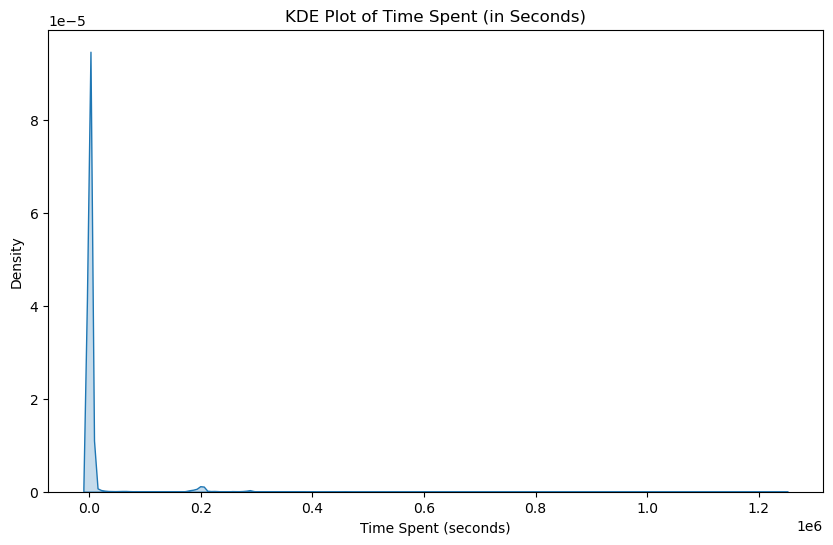

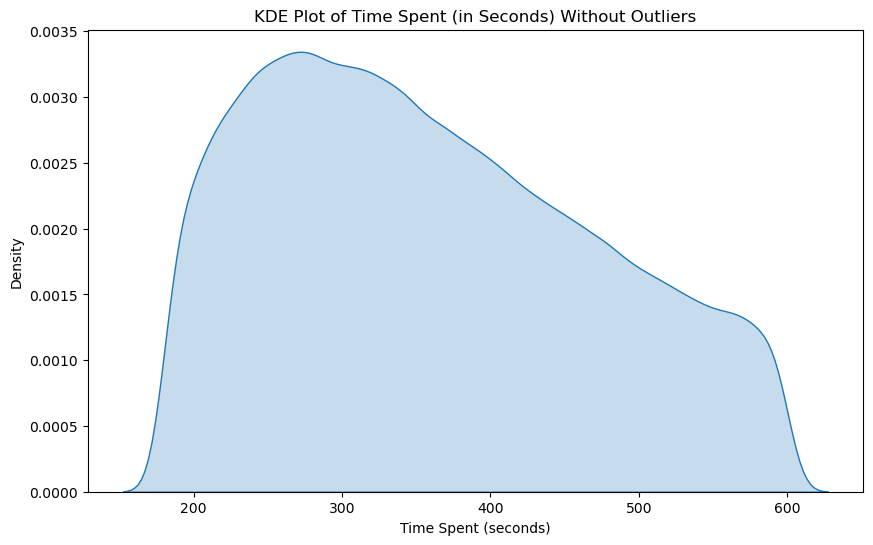

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# time_spent_hrminsec= df_nps_tkt[df_nps_tkt['date_flight_local']>='2023-01-01']['delay']
time_spent_hrminsec= df_nps_tkt[df_nps_tkt['date_flight_local']>='2023-01-01']['time_spent_hrminsec']
# Identify and remove outliers
Q1 = time_spent_hrminsec.quantile(0.05)
Q3 = time_spent_hrminsec.quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_time_spent = time_spent_hrminsec[(time_spent_hrminsec >= 180) & (time_spent_hrminsec <= 600)]
# filtered_time_spent = time_spent_hrminsec[(time_spent_hrminsec <= 50) & (time_spent_hrminsec >= -50)]

# Generate the KDE plot without outliers
plt.figure(figsize=(10, 6))
sns.kdeplot(time_spent_hrminsec, shade=True)

# Add titles and labels
plt.title('KDE Plot of Time Spent (in Seconds)')
plt.xlabel('Time Spent (seconds)')
plt.ylabel('Density')

# Display the plot
plt.show()

# Generate the KDE plot without outliers
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_time_spent, shade=True)

# Add titles and labels
plt.title('KDE Plot of Time Spent (in Seconds) Without Outliers')
plt.xlabel('Time Spent (seconds)')
plt.ylabel('Density')

# Display the plot
plt.show()


In [38]:
# df_nps_tkt = df_nps_tkt[(df_nps_tkt['time_spent_hrminsec']<600) & (df_nps_tkt['time_spent_hrminsec']>180)]

#### Select column

In [39]:
df_nps_tkt[['country_aggr']]

,country_aggr
0,EUROPA
1,AMERICA NORTE
2,ESPAÑA
3,ESPAÑA
4,EUROPA
...,...
835027,AMERICA SUR
835028,ESPAÑA
835029,ESPAÑA
835030,AMERICA CENTRO


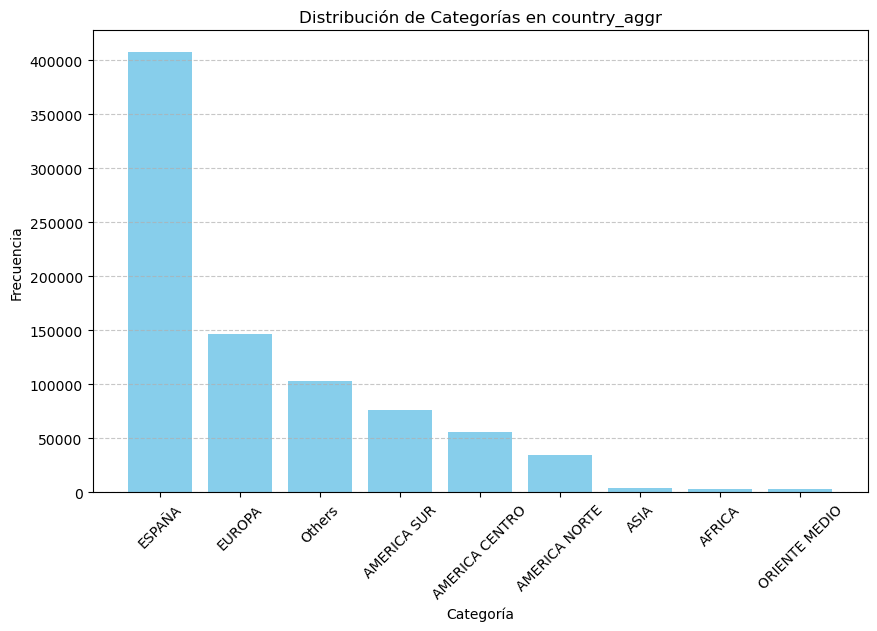

In [40]:
# Contamos las ocurrencias de cada categoría
category_counts = df_nps_tkt['country_aggr'].value_counts()

# Creamos el histograma
plt.figure(figsize=(10, 6))  # Tamaño del gráfico para mayor claridad
plt.bar(category_counts.index, category_counts.values, color='skyblue')  # Bar plot
plt.title('Distribución de Categorías en country_aggr')  # Título del gráfico
plt.xlabel('Categoría')  # Etiqueta para el eje X
plt.ylabel('Frecuencia')  # Etiqueta para el eje Y
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregamos una cuadrícula en el eje Y para referencia
plt.show()


In [41]:
# Crear una nueva columna 'eng_pun_100_punctuality' basada en la condición de 'otp15_takeoff'
df_nps_tkt['eng_punctuality'] = np.where(
    df_nps_tkt['otp15_takeoff'] == 1,
    df_nps_tkt['pun_100_punctuality'] / 2,
    df_nps_tkt['pun_100_punctuality']
)


In [42]:
columns_to_select = ['respondent_id','cabin_in_surveyed_flight', 'haul','date_flight_local'] + touchpoints + ['eng_punctuality','otp15_takeoff', 'delay', 'delay_departure','ticket_price','load_factor','country_aggr'] + labels + labels_multi
# + [col for col in df_nps_tkt_select.columns if 'issues_' in col]
df_nps_tkt_selected = df_nps_tkt[columns_to_select]

In [43]:
# One-hot encoding
# df_nps_tkt_selected = pd.get_dummies(df_nps_tkt_selected, columns=['country_aggr'])

In [44]:
# Target encoding
# Calcula el promedio de la variable objetivo para cada categoría en 'country_aggr'
mean_target_per_category = df_nps_tkt_selected.groupby('country_aggr')['promoter_binary'].mean() - df_nps_tkt_selected.groupby('country_aggr')['detractor_binary'].mean()

# Mapea estos promedios a tu columna categórica original
df_nps_tkt_selected['country_aggr'] = df_nps_tkt_selected['country_aggr'].map(mean_target_per_category)

# Ahora 'country_aggr_encoded' contiene los valores de target encoding para la columna 'country_aggr'


In [45]:
mean_target_per_category

country_aggr
AFRICA           0.212
AMERICA CENTRO   0.469
AMERICA NORTE    0.161
AMERICA SUR      0.334
ASIA             0.065
ESPAÑA           0.343
EUROPA           0.221
ORIENTE MEDIO    0.105
Others           0.285
dtype: float64

In [46]:
df_nps_tkt_selected['country_aggr']

0        0.221
1        0.161
2        0.343
3        0.343
4        0.221
          ... 
835027   0.334
835028   0.343
835029   0.343
835030   0.469
835031   0.343
Name: country_aggr, Length: 835032, dtype: float64

### Input ticket_price

In [47]:
df_nps_tkt = df_nps_tkt_selected.copy()

In [48]:
features_dummy = ['ticket_price', 'load_factor']+['eng_punctuality','bkg_200_journey_preparation', 'pfl_100_checkin', 
                  'pfl_200_security', 'pfl_300_lounge', 'pfl_500_boarding', 'ifl_300_cabin', 
                  'ifl_200_flight_crew_annoucements', 'ifl_600_wifi', 'ifl_500_ife', 'ifl_400_food_drink', 
                  'ifl_100_cabin_crew', 'arr_100_arrivals', 'con_100_connections', 
                  'loy_200_loyalty_programme', 'img_310_ease_contact_phone']

# features_dummy = ['delay','ticket_price','load_factor']
labels = ['promoter_binary', 'detractor_binary']

df_nps_tkt = df_nps_tkt[['respondent_id', 'cabin_in_surveyed_flight', 'haul', 'date_flight_local']+features_dummy+labels]

In [49]:
# Ensure date_flight_local is a datetime type if not already
df_nps_tkt['date_flight_local'] = pd.to_datetime(df_nps_tkt['date_flight_local'])

# Extract month and year from date_flight_local and create new columns
df_nps_tkt['month'] = df_nps_tkt['date_flight_local'].dt.month
df_nps_tkt['year'] = df_nps_tkt['date_flight_local'].dt.year


In [50]:
df_nps_tkt['date_flight_local'].min()

Timestamp('2017-01-09 00:00:00')

0         2017
1         2017
2         2017
3         2017
4         2017
          ... 
835027    2024
835028    2024
835029    2024
835030    2024
835031    2024
Name: year, Length: 835032, dtype: int32


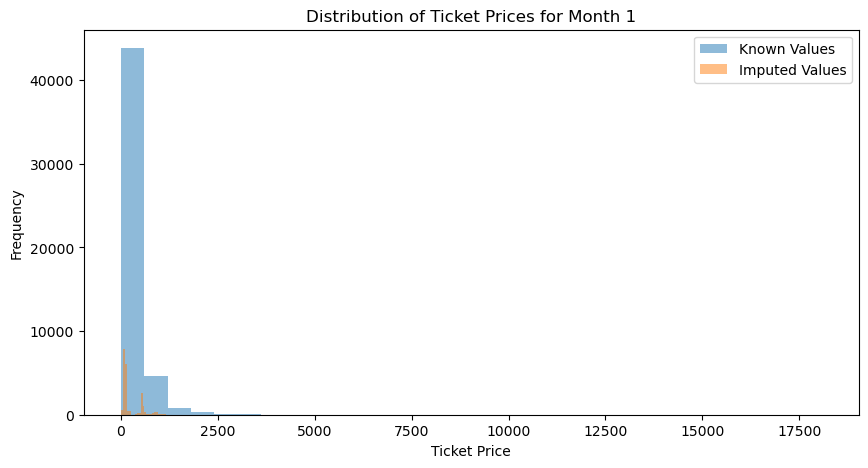

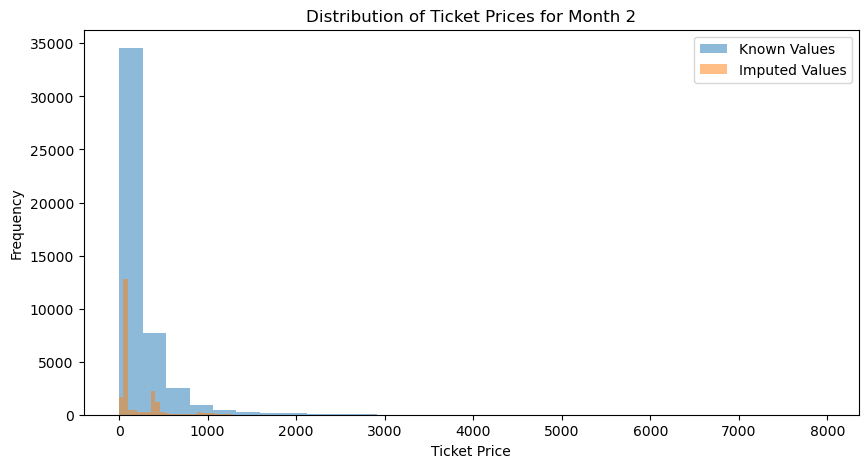

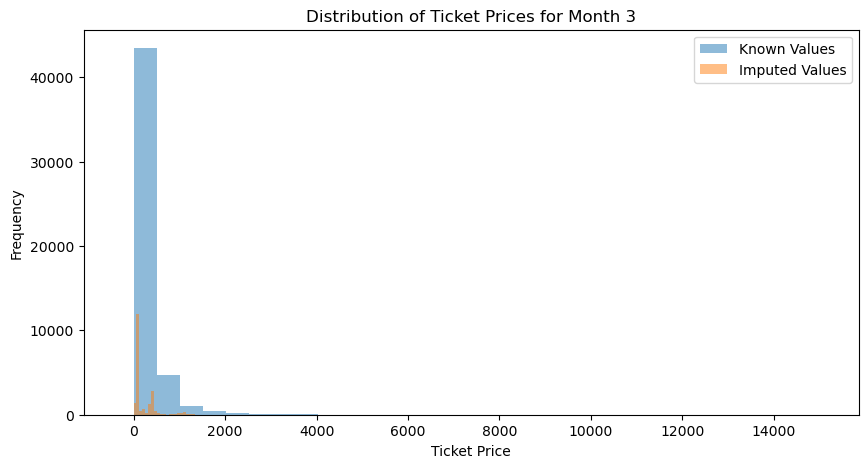

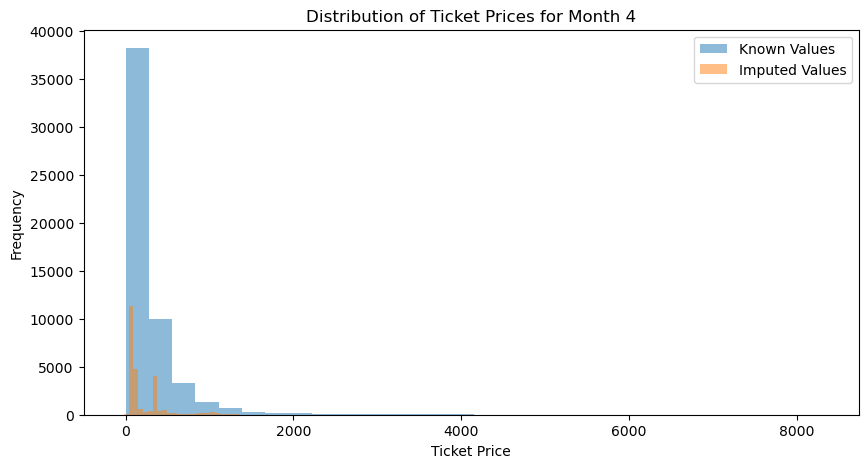

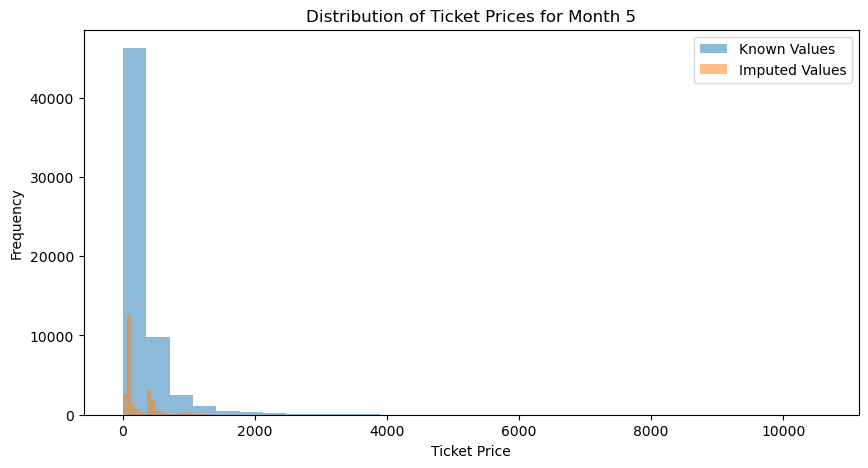

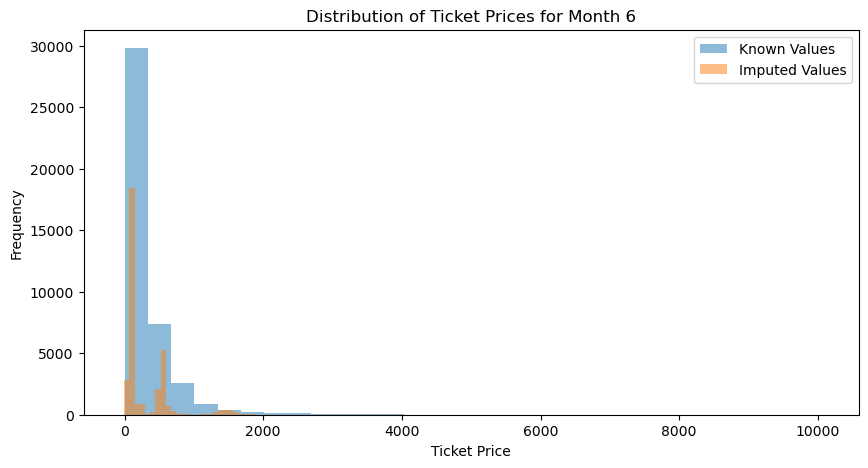

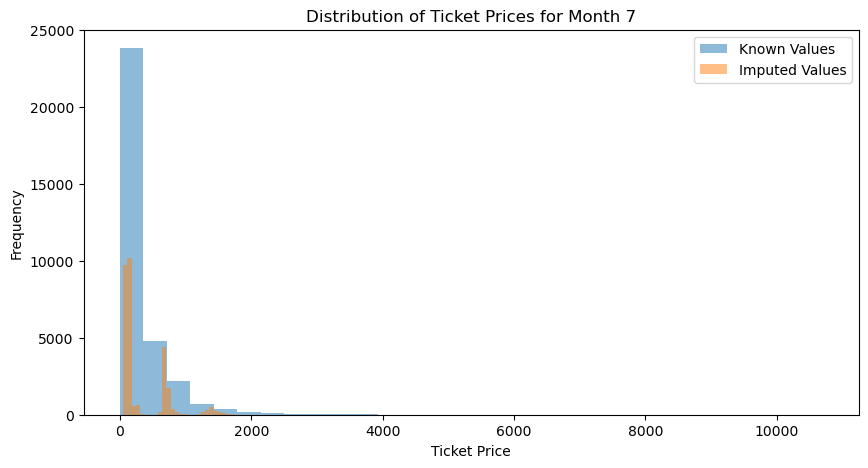

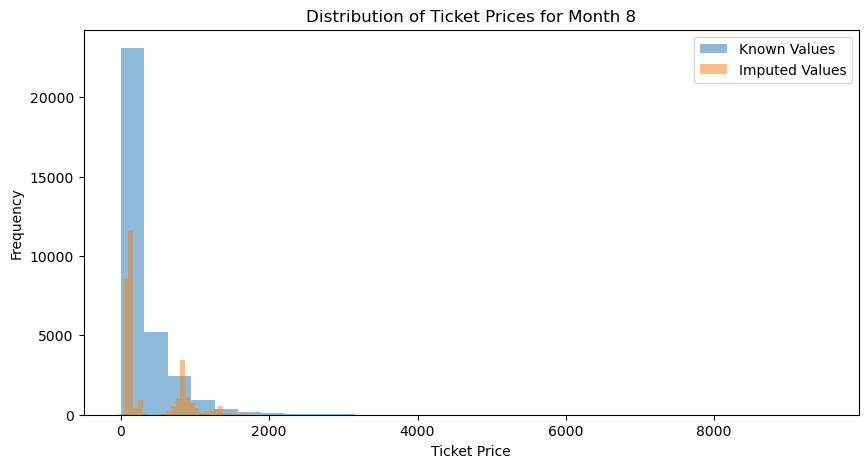

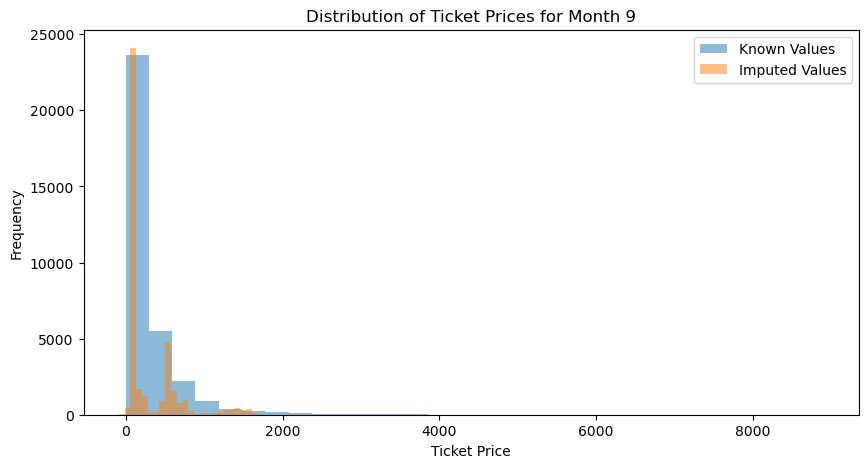

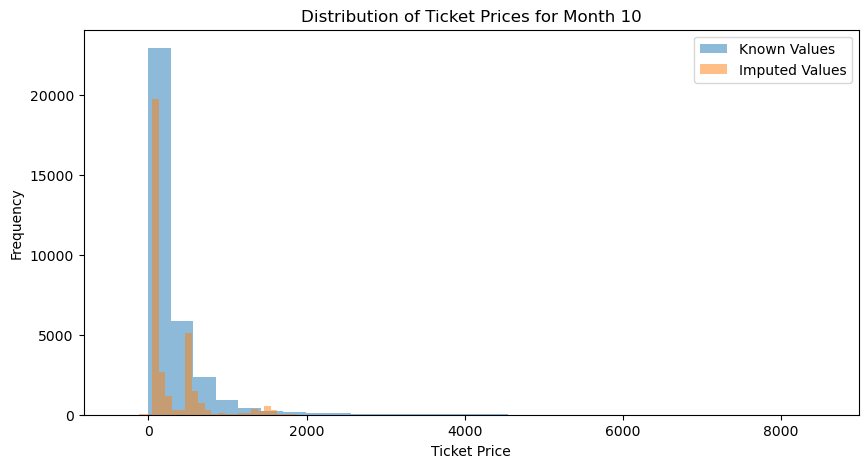

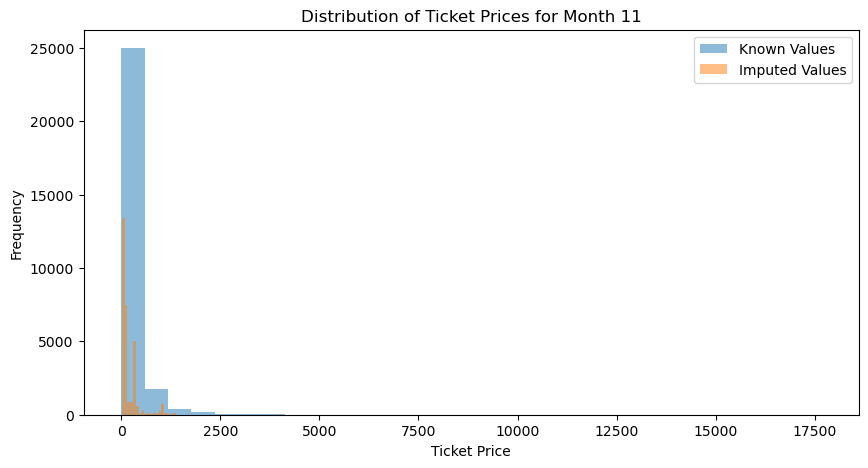

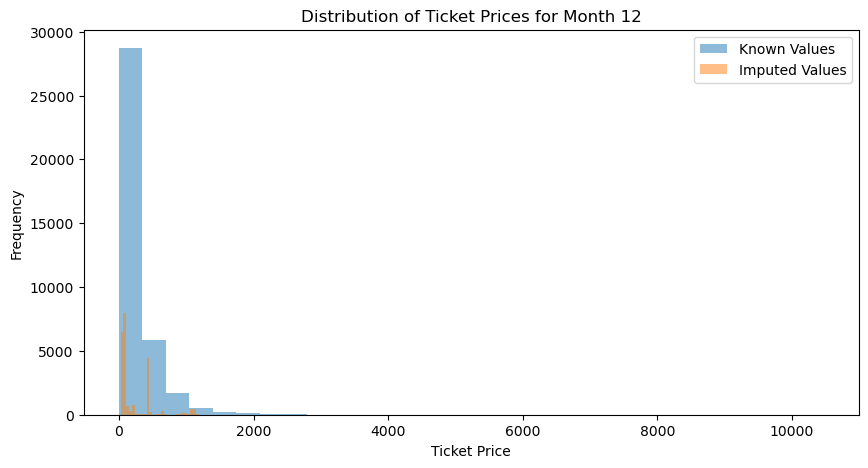

In [51]:
# Assuming df_nps_tkt is your DataFrame and it's already loaded
# Convert 'date_flight_local' to datetime and extract 'month' and 'year' if not already done
df_nps_tkt['date_flight_local'] = pd.to_datetime(df_nps_tkt['date_flight_local'])
df_nps_tkt['month'] = df_nps_tkt['date_flight_local'].dt.month
df_nps_tkt['year'] = df_nps_tkt['date_flight_local'].dt.year
print(df_nps_tkt['year'])
# Identify categorical and numerical columns; make sure 'month' and 'year' are not in these lists
categorical_features = df_nps_tkt.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_features = df_nps_tkt.select_dtypes(include=['int32', 'int64', 'float64']).columns.drop(['ticket_price', 'month', 'year']).tolist()

# Define the preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

# Define the model pipeline
pipeline = make_pipeline(
    preprocessor,
    GradientBoostingRegressor(random_state=42)
)

# Loop over each month to train a model and impute missing values
for month in sorted(df_nps_tkt['month'].unique()):
    # Filter the data for the specific month
    df_month = df_nps_tkt[df_nps_tkt['month'] == month]
    
    # Split data into features and target
    X = df_month.drop(columns=['ticket_price', 'date_flight_local', 'month', 'year'])
    y = df_month['ticket_price']
    
    # Further split your data into training and missing data (for imputation)
    X_train = X.loc[y.notna()]
    y_train = y.loc[y.notna()]
    
    if len(X_train) > 0:
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Identify indices where ticket_price is NaN for imputation
        idx_missing = y[y.isna()].index
        
        # Predict missing ticket_price values
        X_missing = X.loc[idx_missing]
        if len(X_missing) > 0:
            imputed_values = pipeline.predict(X_missing)
            
            # Fill in the missing values in the original DataFrame
            df_nps_tkt.loc[idx_missing, 'ticket_price'] = imputed_values

            # Verification: Distribution comparison
            plt.figure(figsize=(10, 5))
            plt.hist(y_train, bins=30, alpha=0.5, label='Known Values')
            plt.hist(imputed_values, bins=30, alpha=0.5, label='Imputed Values')
            plt.title(f'Distribution of Ticket Prices for Month {month}')
            plt.xlabel('Ticket Price')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()


# Training

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss

def calculate_classification_scores(y_true, y_pred, y_prob):
    """ Use classification measures to evaluate the model."""
    
    sample_size = len(y_true)
    pct_target = sum(y_true) / sample_size
    pct_pred = sum(y_pred) / sample_size
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Manejo especial para log_loss cuando y_true contiene solo una clase
    if len(set(y_true)) > 1:
        loss = log_loss(y_true, y_prob)
    else:
        loss = None  # O manejar de otra manera que tenga sentido para tu análisis
    
    score_dict = {
        "sample size": sample_size,
        "len_y_pred": len(y_pred),
        "len_y_prob": len(y_prob),
        "pct_target": pct_target, 
        "pct_pred": pct_pred,
        "confusion_matrix": cm, 
        "accuracy": accuracy, 
        "precision": precision, 
        "recall": recall, 
        "f1": f1,
        "log_loss": loss
    }
    
    return score_dict


from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostClassifier, Pool
import pandas as pd

def train_test_predict_cv_ctb(df, features, labels, n_splits=5):
    result_dict = {}
    result_dict_ch = {}
    
    # Convertir 'date_flight_local' a datetime si no lo es
    df['date_flight_local'] = pd.to_datetime(df['date_flight_local'])
    
    # Si labels es una sola etiqueta, conviértela en una lista para un manejo uniforme
    labels = [labels] if isinstance(labels, str) else labels

    # Construyendo la lista de todas las columnas necesarias
    all_features = features + ['cabin_in_surveyed_flight', 'haul', 'date_flight_local'] + labels

    # Dividiendo el dataset
    train_df, test_df = train_test_split(
        df,
        stratify=df["date_flight_local"].dt.year,
        test_size=0.2,
        random_state=1
    )
    
    test_df=df[(df['date_flight_local'].dt.year==2024) & (df['date_flight_local'].dt.month==1)] # Para comprobar metricas d eun mes particular

    # Preparación para validación cruzada y entrenamiento del modelo
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # cat_features = ['otp15_takeoff']  # Ajusta según tus características categóricas
    cat_features = []
    
    for target_label in labels:
        # Create a dictionary to set feature weights
        # feature_weights = {feature: 10.0 if feature == 'otp15_takeoff' else 1.0 for feature in features}
        feature_weights = {}
        clf = CatBoostClassifier(cat_features=cat_features, feature_weights = feature_weights,  random_seed=0, verbose=0)
        
        cv_scores = []
        for train_index, val_index in kf.split(train_df):
            # Aquí seleccionamos solo las columnas de características para el entrenamiento
            X_train_fold = train_df.iloc[train_index][features]
            X_val_fold = train_df.iloc[val_index][features]
            y_train_fold = train_df.iloc[train_index][target_label]
            y_val_fold = train_df.iloc[val_index][target_label]

            train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features)
            val_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features)

            clf.fit(train_pool, eval_set=val_pool, early_stopping_rounds=10, verbose=False)
            cv_scores.append(clf.get_best_score())

        # Realizar predicciones y calcular métricas para los conjuntos completos
        train_pred = clf.predict(train_df[features])
        train_pred_prob = clf.predict_proba(train_df[features])
        test_pred = clf.predict(test_df[features])
        test_pred_prob = clf.predict_proba(test_df[features])

        train_metrics = calculate_classification_scores(train_df[target_label], train_pred, train_pred_prob)
        test_metrics = calculate_classification_scores(test_df[target_label], test_pred, test_pred_prob)

        result_dict[target_label] = {
            "cv_scores": cv_scores,
            "train": {"model": clf, "y_true": train_df[target_label], "y_pred": train_pred, "y_prob": train_pred_prob, "metrics": train_metrics},
            "test": {"model": clf, "y_true": test_df[target_label], "y_pred": test_pred, "y_prob": test_pred_prob, "metrics": test_metrics}
        }

        # Encuentra todas las combinaciones únicas de 'cabin_in_surveyed_flight' y 'haul'
        combinations = df[['cabin_in_surveyed_flight', 'haul']].drop_duplicates()

        for index, row in combinations.iterrows():
            cabin = row['cabin_in_surveyed_flight']
            haul = row['haul']
            cabin_haul_key = f"{cabin}_{haul}"  # Clave única para cada combinación

            # Filtrar train_df y test_df por cabin y haul
            train_ch_df = train_df[(train_df['cabin_in_surveyed_flight'] == cabin) & (train_df['haul'] == haul)]
            test_ch_df = test_df[(test_df['cabin_in_surveyed_flight'] == cabin) & (test_df['haul'] == haul)]

            if not train_ch_df.empty and not test_ch_df.empty:
                    train_pred_ch = clf.predict(train_ch_df[features])
                    train_pred_prob_ch = clf.predict_proba(train_ch_df[features])
                    test_pred_ch = clf.predict(test_ch_df[features])
                    test_pred_prob_ch = clf.predict_proba(test_ch_df[features])

                    train_metrics_ch = calculate_classification_scores(train_ch_df[target_label], train_pred_ch, train_pred_prob_ch)
                    test_metrics_ch = calculate_classification_scores(test_ch_df[target_label], test_pred_ch, test_pred_prob_ch)

                    result_dict_ch[target_label] = result_dict_ch.get(target_label, {})
                    result_dict_ch[target_label][cabin_haul_key] = {
                        "train": {"y_true": train_ch_df[target_label], "y_pred": train_pred_ch, "y_prob": train_pred_prob_ch, "metrics": train_metrics_ch},
                        "test": {"y_true": test_ch_df[target_label], "y_pred": test_pred_ch, "y_prob": test_pred_prob_ch, "metrics": test_metrics_ch}
                    }
    
    return result_dict, result_dict_ch



from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.impute import SimpleImputer

def calculate_classification_scores(y_true, y_pred, y_prob):
    return {
        "classification_report": classification_report(y_true, y_pred, output_dict=True),
        "roc_auc_score": roc_auc_score(y_true, y_prob[:, 1]),
        "log_loss": log_loss(y_true, y_prob)
    }

def train_test_predict_cv_lr(df, features, labels, n_splits=5):
    result_dict = {}
    result_dict_ch = {}
    
    # Convert 'date_flight_local' to datetime if it's not already
    df['date_flight_local'] = pd.to_datetime(df['date_flight_local'])
    
    # If labels is a single label, convert it to a list for uniform handling
    labels = [labels] if isinstance(labels, str) else labels

    # Building the list of all necessary columns
    all_features = features + ['cabin_in_surveyed_flight', 'haul', 'date_flight_local'] + labels

    # Splitting the dataset
    train_df, test_df = train_test_split(
        df,
        stratify=df["date_flight_local"].dt.year,
        test_size=0.2,
        random_state=1
    )
    
    test_df = df[(df['date_flight_local'].dt.year == 2024) & (df['date_flight_local'].dt.month == 1)]  # For checking metrics for a particular month

    # Preparation for cross-validation and model training
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    # Imputer to fill NaN values
    imputer = SimpleImputer(strategy='median')

    for target_label in labels:
        clf = LogisticRegression(random_state=0, max_iter=1000)
        
        cv_scores = []
        for train_index, val_index in kf.split(train_df):
            # Selecting only feature columns for training
            X_train_fold = train_df.iloc[train_index][features]
            X_val_fold = train_df.iloc[val_index][features]
            y_train_fold = train_df.iloc[train_index][target_label]
            y_val_fold = train_df.iloc[val_index][target_label]

            # Impute missing values
            X_train_fold = imputer.fit_transform(X_train_fold)
            X_val_fold = imputer.transform(X_val_fold)

            clf.fit(X_train_fold, y_train_fold)
            val_pred = clf.predict(X_val_fold)
            val_pred_prob = clf.predict_proba(X_val_fold)

            cv_scores.append({
                "classification_report": classification_report(y_val_fold, val_pred, output_dict=True),
                "roc_auc_score": roc_auc_score(y_val_fold, val_pred_prob[:, 1]),
                "log_loss": log_loss(y_val_fold, val_pred_prob)
            })

        # Making predictions and calculating metrics for the full sets
        X_train_full = imputer.fit_transform(train_df[features])
        X_test_full = imputer.transform(test_df[features])

        train_pred = clf.predict(X_train_full)
        train_pred_prob = clf.predict_proba(X_train_full)
        test_pred = clf.predict(X_test_full)
        test_pred_prob = clf.predict_proba(X_test_full)

        train_metrics = calculate_classification_scores(train_df[target_label], train_pred, train_pred_prob)
        test_metrics = calculate_classification_scores(test_df[target_label], test_pred, test_pred_prob)

        result_dict[target_label] = {
            "cv_scores": cv_scores,
            "train": {"model": clf, "y_true": train_df[target_label], "y_pred": train_pred, "y_prob": train_pred_prob, "metrics": train_metrics},
            "test": {"model": clf, "y_true": test_df[target_label], "y_pred": test_pred, "y_prob": test_pred_prob, "metrics": test_metrics}
        }

        # Find all unique combinations of 'cabin_in_surveyed_flight' and 'haul'
        combinations = df[['cabin_in_surveyed_flight', 'haul']].drop_duplicates()

        for index, row in combinations.iterrows():
            cabin = row['cabin_in_surveyed_flight']
            haul = row['haul']
            cabin_haul_key = f"{cabin}_{haul}"  # Unique key for each combination

            # Filter train_df and test_df by cabin and haul
            train_ch_df = train_df[(train_df['cabin_in_surveyed_flight'] == cabin) & (train_df['haul'] == haul)]
            test_ch_df = test_df[(test_df['cabin_in_surveyed_flight'] == cabin) & (test_df['haul'] == haul)]

            if not train_ch_df.empty and not test_ch_df.empty:
                X_train_ch = imputer.transform(train_ch_df[features])
                X_test_ch = imputer.transform(test_ch_df[features])

                train_pred_ch = clf.predict(X_train_ch)
                train_pred_prob_ch = clf.predict_proba(X_train_ch)
                test_pred_ch = clf.predict(X_test_ch)
                test_pred_prob_ch = clf.predict_proba(X_test_ch)

                train_metrics_ch = calculate_classification_scores(train_ch_df[target_label], train_pred_ch, train_pred_prob_ch)
                test_metrics_ch = calculate_classification_scores(test_ch_df[target_label], test_pred_ch, test_pred_prob_ch)

                result_dict_ch[target_label] = result_dict_ch.get(target_label, {})
                result_dict_ch[target_label][cabin_haul_key] = {
                    "train": {"y_true": train_ch_df[target_label], "y_pred": train_pred_ch, "y_prob": train_pred_prob_ch, "metrics": train_metrics_ch},
                    "test": {"y_true": test_ch_df[target_label], "y_pred": test_pred_ch, "y_prob": test_pred_prob_ch, "metrics": test_metrics_ch}
                }
    
    return result_dict, result_dict_ch



def train_models(df, features, labels, start_date, end_date, n_splits=10):
    """
    Entrena modelos para predecir promotores y detractores dentro de un rango de fechas.

    Args:
    - df: DataFrame con los datos.
    - features: Lista de características a usar.
    - labels: Lista de etiquetas a predecir.
    - start_date: Fecha de inicio para los datos de entrenamiento.
    - end_date: Fecha de fin para los datos de entrenamiento.
    - n_splits: Número de divisiones para validación cruzada.

    Returns:
    - Un diccionario con los modelos entrenados, los conjuntos de datos de entrenamiento y prueba.
    """
    # Filtrar el DataFrame por el rango de fechas
    df_filtered = df[(df['date_flight_local'] >= start_date) & (df['date_flight_local'] < end_date)]
    
    # Llamada a la función existente para entrenar y evaluar modelos
    result_dict, result_dict_ch = train_test_predict_cv_ctb(df_filtered, features, labels, n_splits)
    
    # Guardar modelos
    models = {label: result_dict[label]['train']['model'] for label in labels}
    
    # Guardar métricas
    metrics_train = {label: result_dict[label]['train']['metrics'] for label in labels}
    metrics_test = {label: result_dict[label]['test']['metrics'] for label in labels}
    
    # Guardar conjuntos de entrenamiento y prueba
    # train_set = result_dict["train_set"]
    # test_set = result_dict["test_set"]
    
    return {"models": models, "metrics_train": metrics_train, "metrics_test": metrics_test}, result_dict_ch

In [53]:
pip install xgboost

  Using cached xgboost-2.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached xgboost-2.1.0-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
Using cached nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl (190.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [54]:
df_nps_tkt.to_csv('historic_with_interactions.csv')

In [55]:
df_nps_tkt.columns

Index(['respondent_id', 'cabin_in_surveyed_flight', 'haul',
       'date_flight_local', 'ticket_price', 'load_factor', 'eng_punctuality',
       'bkg_200_journey_preparation', 'pfl_100_checkin', 'pfl_200_security',
       'pfl_300_lounge', 'pfl_500_boarding', 'ifl_300_cabin',
       'ifl_200_flight_crew_annoucements', 'ifl_600_wifi', 'ifl_500_ife',
       'ifl_400_food_drink', 'ifl_100_cabin_crew', 'arr_100_arrivals',
       'con_100_connections', 'loy_200_loyalty_programme',
       'img_310_ease_contact_phone', 'promoter_binary', 'detractor_binary',
       'month', 'year'],
      dtype='object')

In [56]:
# Asume que df_nps_tkt_select es tu DataFrame y ya ha sido cargado correctamente
train_results, cabin_haul_results = train_models(df=df_nps_tkt, 
                             features=features_dummy, 
                             labels=labels, 
                             start_date='2023-01-01', 
                             end_date='2024-06-14', 
                             n_splits=20)

In [57]:
train_results['metrics_train']

{'promoter_binary': {'classification_report': {'0': {'precision': 0.8580025975595023,
    'recall': 0.8103538036927949,
    'f1-score': 0.8334977682091759,
    'support': 140219.0},
   '1': {'precision': 0.8625530441254762,
    'recall': 0.8987257922061136,
    'f1-score': 0.8802679642890111,
    'support': 185684.0},
   'accuracy': 0.8607039517893361,
   'macro avg': {'precision': 0.8602778208424893,
    'recall': 0.8545397979494542,
    'f1-score': 0.8568828662490935,
    'support': 325903.0},
   'weighted avg': {'precision': 0.8605952251823111,
    'recall': 0.8607039517893361,
    'f1-score': 0.8601451973181073,
    'support': 325903.0}},
  'roc_auc_score': 0.934659867922367,
  'log_loss': 0.3186216744731594},
 'detractor_binary': {'classification_report': {'0': {'precision': 0.9327676799128167,
    'recall': 0.9598603000664856,
    'f1-score': 0.9461200770615545,
    'support': 249678.0},
   '1': {'precision': 0.854696765400954,
    'recall': 0.7733814365365693,
    'f1-score': 0.

In [58]:
train_results['metrics_test']

{'promoter_binary': {'classification_report': {'0': {'precision': 0.8551746941474705,
    'recall': 0.8019638242894057,
    'f1-score': 0.8277149562620013,
    'support': 9675.0},
   '1': {'precision': 0.8626227862622786,
    'recall': 0.9015361558636193,
    'f1-score': 0.8816503004543456,
    'support': 13345.0},
   'accuracy': 0.8596872284969591,
   'macro avg': {'precision': 0.8588987402048746,
    'recall': 0.8517499900765125,
    'f1-score': 0.8546826283581734,
    'support': 23020.0},
   'weighted avg': {'precision': 0.8594924521523407,
    'recall': 0.8596872284969591,
    'f1-score': 0.8589819922414467,
    'support': 23020.0}},
  'roc_auc_score': 0.9347034755441702,
  'log_loss': 0.317310915822921},
 'detractor_binary': {'classification_report': {'0': {'precision': 0.9329099495196223,
    'recall': 0.9642075736325386,
    'f1-score': 0.948300595894946,
    'support': 17825.0},
   '1': {'precision': 0.8612138351098543,
    'recall': 0.7620789220404235,
    'f1-score': 0.808619

In [59]:
cabin_haul_results['detractor_binary']['Business_LH']['test']['metrics']

{'classification_report': {'0': {'precision': 0.929778933680104,
   'recall': 0.9610215053763441,
   'f1-score': 0.9451421017845341,
   'support': 744.0},
  '1': {'precision': 0.8164556962025317,
   'recall': 0.7049180327868853,
   'f1-score': 0.7565982404692082,
   'support': 183.0},
  'accuracy': 0.9104638619201726,
  'macro avg': {'precision': 0.8731173149413178,
   'recall': 0.8329697690816147,
   'f1-score': 0.8508701711268711,
   'support': 927.0},
  'weighted avg': {'precision': 0.9074076796796772,
   'recall': 0.9104638619201726,
   'f1-score': 0.90792146896824,
   'support': 927.0}},
 'roc_auc_score': 0.9407867677301839,
 'log_loss': 0.22702400923541466}

In [61]:
import pickle

# Assuming you have already defined and trained model_prom and model_det as follows:
model_prom = train_results['models']['promoter_binary']
model_det = train_results['models']['detractor_binary']

# Save model_prom to a file
with open('model_prom.pkl', 'wb') as file:
    pickle.dump(model_prom, file)

# Save model_det to a file
with open('model_det.pkl', 'wb') as file:
    pickle.dump(model_det, file)

# Predict and Explain

In [80]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

def calculate_SHAP_and_probability_binary(model_promoter, model_detractor, df):
    # Extraer ID y fechas, manteniendo el índice
    id_df = df[['respondent_id', 'date_flight_local', 'cabin_in_surveyed_flight', 'haul']]
    
    # Preparar el conjunto de datos para predicciones, excluyendo ID y fechas
    test_set = df.drop(['respondent_id', 'date_flight_local', 'cabin_in_surveyed_flight', 'haul'], axis=1, errors='ignore')
    
    # Predicciones y probabilidades para promotores
    promoter_test_set = test_set.drop(['detractor_binary', 'promoter_binary'], axis=1, errors='ignore')
    predictions_promoter = pd.DataFrame(model_promoter.predict(promoter_test_set), index=promoter_test_set.index, columns=["prediction_prom"])
    proba_promoter = pd.DataFrame(model_promoter.predict_proba(promoter_test_set)[:, 1], index=promoter_test_set.index, columns=["out_prob_prom"])
    
    # Predicciones y probabilidades para detractores
    detractor_test_set = test_set.drop(['promoter_binary', 'detractor_binary'], axis=1, errors='ignore')
    predictions_detractor = pd.DataFrame(model_detractor.predict(detractor_test_set), index=detractor_test_set.index, columns=["prediction_det"])
    proba_detractor = pd.DataFrame(model_detractor.predict_proba(detractor_test_set)[:, 1], index=detractor_test_set.index, columns=["out_prob_det"])
    
    # Combinar resultados de predicción, manteniendo el índice original
    prediction = pd.concat([id_df, test_set, predictions_promoter, proba_promoter, predictions_detractor, proba_detractor], axis=1)
    
    # SHAP values y explicadores para el modelo promotor
    shap_Explainer_promoter = shap.TreeExplainer(model_promoter)
    shap_values_promoter = shap_Explainer_promoter.shap_values(promoter_test_set)
    feature_names = [i for i in promoter_test_set.columns]
    shap_values_prom = pd.DataFrame(shap_values_promoter, index=promoter_test_set.index, columns=[f"{i}_prom" for i in feature_names])
    shap_values_prom["base_value_prom"] = shap_Explainer_promoter.expected_value
    shap_values_prom["out_value_prom"] = shap_values_prom.sum(axis=1)
    
    # SHAP values y explicadores para el modelo detractor
    shap_Explainer_detractor = shap.TreeExplainer(model_detractor)
    shap_values_detractor = shap_Explainer_detractor.shap_values(detractor_test_set)
    shap_values_det = pd.DataFrame(shap_values_detractor, index=detractor_test_set.index, columns=[f"{i}_det" for i in feature_names])
    shap_values_det["base_value_det"] = shap_Explainer_detractor.expected_value
    shap_values_det["out_value_det"] = shap_values_det.sum(axis=1)
    
    # Combinar SHAP values con predicciones, manteniendo el índice original
    output_df = pd.concat([prediction, shap_values_prom, shap_values_det], axis=1)
    
    # Devolver el dataframe de salida
    return output_df

def calculate_SHAP_and_probability_binary_lr(model_promoter, model_detractor, df):
    # Extract ID and dates, maintaining the index
    id_df = df[['respondent_id', 'date_flight_local', 'cabin_in_surveyed_flight', 'haul']]
    
    # Prepare the dataset for predictions, excluding ID and dates
    test_set = df.drop(['respondent_id', 'date_flight_local', 'cabin_in_surveyed_flight', 'haul'], axis=1, errors='ignore')
    
    # Predictions and probabilities for promoters
    promoter_test_set = test_set.drop(['detractor_binary', 'promoter_binary'], axis=1, errors='ignore')
    predictions_promoter = pd.DataFrame(model_promoter.predict(promoter_test_set), index=promoter_test_set.index, columns=["prediction_prom"])
    proba_promoter = pd.DataFrame(model_promoter.predict_proba(promoter_test_set)[:, 1], index=promoter_test_set.index, columns=["out_prob_prom"])
    
    # Predictions and probabilities for detractors
    detractor_test_set = test_set.drop(['promoter_binary', 'detractor_binary'], axis=1, errors='ignore')
    predictions_detractor = pd.DataFrame(model_detractor.predict(detractor_test_set), index=detractor_test_set.index, columns=["prediction_det"])
    proba_detractor = pd.DataFrame(model_detractor.predict_proba(detractor_test_set)[:, 1], index=detractor_test_set.index, columns=["out_prob_det"])
    
    # Combine prediction results, maintaining the original index
    prediction = pd.concat([id_df, test_set, predictions_promoter, proba_promoter, predictions_detractor, proba_detractor], axis=1)
    
    # SHAP values and explainers for the promoter model
    shap_Explainer_promoter = shap.LinearExplainer(model_promoter, promoter_test_set, feature_perturbation="interventional")
    shap_values_promoter = shap_Explainer_promoter.shap_values(promoter_test_set)
    feature_names = promoter_test_set.columns
    shap_values_prom = pd.DataFrame(shap_values_promoter, index=promoter_test_set.index, columns=[f"{i}_prom" for i in feature_names])
    shap_values_prom["base_value_prom"] = shap_Explainer_promoter.expected_value  # Expected value for the positive class
    shap_values_prom["out_value_prom"] = shap_values_prom.sum(axis=1) + shap_Explainer_promoter.expected_value
    
    # SHAP values and explainers for the detractor model
    shap_Explainer_detractor = shap.LinearExplainer(model_detractor, detractor_test_set, feature_perturbation="interventional")
    shap_values_detractor = shap_Explainer_detractor.shap_values(detractor_test_set)
    shap_values_det = pd.DataFrame(shap_values_detractor, index=detractor_test_set.index, columns=[f"{i}_det" for i in feature_names])
    shap_values_det["base_value_det"] = shap_Explainer_detractor.expected_value
    shap_values_det["out_value_det"] = shap_values_det.sum(axis=1) + shap_Explainer_detractor.expected_value
    
    # Combine SHAP values with predictions, maintaining the original index
    output_df = pd.concat([prediction, shap_values_prom, shap_values_det], axis=1)
    
    # Return the output dataframe
    return output_df


def from_shap_to_probability_binary(df, features_dummy, label_binary):
    output_df = df.copy()
    
    # Determinar el sufijo basado en el tipo de modelo (promoter o detractor)
    class_suffix = '_prom' if label_binary == 'promoter_binary' else '_det'
    
    # Identificar columnas de SHAP para la clase de interés, asumiendo que ya tienen el sufijo correcto
    shap_columns = [col for col in df.columns if col.endswith(class_suffix)]
    base_value_col = f'base_value{class_suffix}'
    
    # Convertir el valor base a probabilidades y actualizar el nombre de la columna
    output_df[f'base_prob{class_suffix}'] = inv_logit(output_df[base_value_col])
    
    # Convertir valores SHAP a probabilidades sin cambiar los nombres de las columnas
    for col in shap_columns:
        output_df[col] = inv_logit(output_df[col])
    
    # Asegurarse de incluir solo las columnas relevantes en el DataFrame final
    relevant_columns = ['respondent_id', 'date_flight_local','cabin_in_surveyed_flight', 'haul'] + shap_columns + [f'base_prob{class_suffix}'] + features_dummy
    output_df = output_df[relevant_columns]
    return output_df

def adjust_shap_values_binary(shap_values, base_prob, out_prob):
    """Ajustar los valores SHAP para un modelo binario basado en la distancia."""
    # Calcular la distancia total deseada entre la probabilidad base y la de salida
    total_distance = out_prob - base_prob
    # Calcular la suma total de los valores SHAP
    total_shap = np.sum(shap_values)
    # Calcular el factor de ajuste si la suma total de SHAP no es cero
    adjustment_factor = total_distance / total_shap if total_shap != 0 else 0
    # Ajustar los valores SHAP
    return shap_values * adjustment_factor

def from_shap_to_probability_binary(df, features_dummy, label_binary):
    output_df = df.copy()
    
    # Determinar el sufijo basado en el tipo de modelo (promoter o detractor)
    class_suffix = '_prom' if label_binary == 'promoter_binary' else '_det'
    
    # Identificar columnas de SHAP para la clase de interés, asumiendo que ya tienen el sufijo correcto
    shap_columns = [f'{feature}{class_suffix}' for feature in features_dummy if f'{feature}{class_suffix}' in df.columns]
    base_value_col = f'base_value{class_suffix}'
    out_prob_col = f'out_prob{class_suffix}'

    # Calcular la probabilidad base usando softmax o inv_logit según sea apropiado
    output_df[f'base_prob{class_suffix}'] = inv_logit(output_df[base_value_col])

    for index, row in output_df.iterrows():
        # Extraer los valores SHAP para ajustar
        shap_values = row[shap_columns].values
        # Calcular los valores SHAP ajustados
        adjusted_shap_values = adjust_shap_values_binary(shap_values, row[f'base_prob{class_suffix}'], row[out_prob_col])
        # Actualizar el DataFrame con los valores SHAP ajustados
        output_df.loc[index, shap_columns] = adjusted_shap_values

    # Incluir solo las columnas relevantes en el DataFrame final
    relevant_columns = ['respondent_id', 'date_flight_local', 'cabin_in_surveyed_flight', 'haul'] + shap_columns + [f'base_prob{class_suffix}', out_prob_col] + features_dummy
    output_df = output_df[relevant_columns]
    
    return output_df

def predict_and_explain(model_prom, model_det, df, features_dummy):
    """
    Realiza predicciones y genera explicaciones para modelos de promotores y detractores
    para todo el dataframe.

    Args:
    - model_prom: Modelo entrenado para predecir promotores.
    - model_det: Modelo entrenado para predecir detractores.
    - df: DataFrame con los datos.
    - features_dummy: Lista de características utilizadas para las predicciones.

    Returns:
    - Df final con .data, .values, .base_value, y predicciones.
    """
    # 1. Asumiendo que las funciones de cálculo de SHAP y probabilidad ya están implementadas y ajustadas para usar df
    df_contrib = calculate_SHAP_and_probability_binary(model_prom, model_det, df)

    # 3. Convertir valores SHAP a probabilidad
    df_probability_prom = from_shap_to_probability_binary(df_contrib, features_dummy, 'promoter_binary')
    df_probability_det = from_shap_to_probability_binary(df_contrib, features_dummy, 'detractor_binary')

    # 4. Concatenar DataFrames para ambos modelos
    df_probability_prom = df_probability_prom.reset_index(drop=True)
    df_probability_det = df_probability_det.reset_index(drop=True)
    unique_columns_det = [col for col in df_probability_det.columns if col not in df_probability_prom.columns]
    df_probability_binary = pd.concat([df_probability_prom, df_probability_det[unique_columns_det]], axis=1)

    # 5. Calcular columnas NPS con la diferencia entre _prom y _det
    for column in df_probability_binary.columns:
        if '_prom' in column:
            base_name = column.split('_prom')[0]
            det_column = f'{base_name}_det'
            if det_column in df_probability_binary.columns:
                nps_column = f'{base_name}_nps'
                df_probability_binary[nps_column] = df_probability_binary[column] - df_probability_binary[det_column]

    return df_probability_binary


In [ ]:
model_prom=train_results['models']['promoter_binary']
model_det=train_results['models']['detractor_binary']
if 'month' in df_nps_tkt.columns:
    df_nps_tkt = df_nps_tkt.drop(columns=['month','year'])
    
# # Create the SimpleImputer instance with the median strategy
# imputer = SimpleImputer(strategy='median')

# # Fit the imputer on the selected features and transform the data
# df_nps_tkt_imputed = df_nps_tkt.copy()
# df_nps_tkt_imputed[features_dummy] = imputer.fit_transform(df_nps_tkt[features_dummy])

df_probability_binary = predict_and_explain(model_prom, model_det, df_nps_tkt, features_dummy)

In [89]:
df_probability_binary

,respondent_id,date_flight_local,cabin_in_surveyed_flight,haul,ticket_price_prom,load_factor_prom,eng_punctuality_prom,bkg_200_journey_preparation_prom,pfl_100_checkin_prom,pfl_200_security_prom,pfl_300_lounge_prom,pfl_500_boarding_prom,ifl_300_cabin_prom,ifl_200_flight_crew_annoucements_prom,ifl_600_wifi_prom,ifl_500_ife_prom,ifl_400_food_drink_prom,ifl_100_cabin_crew_prom,arr_100_arrivals_prom,con_100_connections_prom,loy_200_loyalty_programme_prom,img_310_ease_contact_phone_prom,base_prob_prom,out_prob_prom,ticket_price,load_factor,eng_punctuality,bkg_200_journey_preparation,pfl_100_checkin,pfl_200_security,pfl_300_lounge,pfl_500_boarding,ifl_300_cabin,ifl_200_flight_crew_annoucements,ifl_600_wifi,ifl_500_ife,ifl_400_food_drink,ifl_100_cabin_crew,arr_100_arrivals,con_100_connections,loy_200_loyalty_programme,img_310_ease_contact_phone,ticket_price_det,load_factor_det,eng_punctuality_det,bkg_200_journey_preparation_det,pfl_100_checkin_det,pfl_200_security_det,pfl_300_lounge_det,pfl_500_boarding_det,ifl_300_cabin_det,ifl_200_flight_crew_annoucements_det,ifl_600_wifi_det,ifl_500_ife_det,ifl_400_food_drink_det,ifl_100_cabin_crew_det,arr_100_arrivals_det,con_100_connections_det,loy_200_loyalty_programme_det,img_310_ease_contact_phone_det,base_prob_det,out_prob_det,ticket_price_nps,load_factor_nps,eng_punctuality_nps,bkg_200_journey_preparation_nps,pfl_100_checkin_nps,pfl_200_security_nps,pfl_300_lounge_nps,pfl_500_boarding_nps,ifl_300_cabin_nps,ifl_200_flight_crew_annoucements_nps,ifl_600_wifi_nps,ifl_500_ife_nps,ifl_400_food_drink_nps,ifl_100_cabin_crew_nps,arr_100_arrivals_nps,con_100_connections_nps,loy_200_loyalty_programme_nps,img_310_ease_contact_phone_nps,base_prob_nps,out_prob_nps
0,3530689,2017-11-01,Economy,MH,0.028,-0.003,0.090,-0.025,0.040,-0.005,0.001,-0.067,-0.059,0.013,-0.001,0.012,-0.056,-0.178,-0.035,-0.010,-0.024,0.006,0.551,0.277,86.180,NaN,9.000,8.000,9.000,9.000,NaN,8.000,7.000,5.000,NaN,NaN,5.000,7.000,8.000,9.000,NaN,NaN,-0.010,-0.003,-0.020,-0.014,-0.016,0.004,0.000,-0.005,-0.006,0.000,0.001,-0.000,0.012,0.032,-0.002,0.008,0.009,-0.007,0.099,0.084,0.038,-0.000,0.110,-0.012,0.055,-0.008,0.000,-0.062,-0.053,0.012,-0.002,0.012,-0.068,-0.210,-0.033,-0.018,-0.033,0.013,0.452,0.193
1,261630,2017-04-04,Economy,MH,0.012,-0.001,-0.050,-0.062,-0.097,0.010,-0.000,-0.096,-0.017,0.007,-0.001,0.004,-0.054,-0.068,-0.053,-0.011,-0.014,-0.050,0.551,0.010,89.970,NaN,7.000,2.000,2.000,5.000,NaN,4.000,7.000,7.000,NaN,NaN,3.000,7.000,7.000,7.000,NaN,0.000,-0.012,0.000,0.001,0.160,0.219,-0.016,0.003,0.175,-0.030,-0.022,0.004,0.001,0.059,0.017,0.000,0.009,0.033,0.180,0.099,0.879,0.024,-0.002,-0.051,-0.222,-0.316,0.026,-0.003,-0.270,0.013,0.029,-0.006,0.002,-0.114,-0.084,-0.053,-0.021,-0.046,-0.229,0.452,-0.870
2,3490188,2017-10-23,Economy,MH,0.010,0.001,0.054,-0.107,-0.051,-0.002,-0.003,0.056,-0.096,0.010,-0.001,0.007,-0.086,-0.134,-0.176,0.006,-0.016,0.005,0.551,0.026,153.273,NaN,9.000,0.000,6.000,8.000,7.000,9.000,5.000,5.000,NaN,NaN,0.000,5.000,3.000,NaN,NaN,NaN,-0.008,-0.004,-0.066,0.228,0.073,0.001,-0.014,-0.038,0.132,-0.014,0.002,-0.002,0.100,0.158,0.276,-0.014,0.025,-0.007,0.099,0.927,0.018,0.005,0.120,-0.335,-0.124,-0.003,0.011,0.094,-0.228,0.024,-0.003,0.009,-0.187,-0.292,-0.452,0.020,-0.041,0.012,0.452,-0.901
3,1022390,2017-06-08,Economy,MH,0.009,0.000,-0.062,-0.053,-0.069,-0.006,0.000,-0.066,-0.056,-0.003,-0.001,0.002,-0.049,-0.128,-0.074,0.006,-0.002,0.003,0.551,0.004,129.530,NaN,3.000,2.000,3.000,8.000,NaN,5.000,6.000,8.000,NaN,NaN,0.000,3.000,5.000,NaN,7.000,NaN,-0.009,-0.003,0.019,0.141,0.137,-0.000,0.002,0.114,0.014,-0.001,0.002,-0.003,0.079,0.263,0.173,-0.018,-0.062,-0.005,0.099,0.942,0.019,0.003,-0.082,-0.194,-0.207,-0.005,-0.002,-0.180,-0.070,-0.002,-0.003,0.006,-0.128,-0.391,-0.247,0.024,0.060,0.008,0.452,-0.938
4,685095,2017-05-21,Economy,LH,-0.026,0.008,-0.166,0.062,-0.044,0.005,0.000,-0.038,-0.091,0.002,-0.002,0.000,-0.038,-0.027,-0.139,-0.034,-0.014,0.004,0.551,0.011,407.498,NaN,1.000,10.000,6.000,6.000,

In [ ]:
# Funciones auxiliares
def calculate_nps(promoters, detractors, total_responses):
    """Calcula el Net Promoter Score (NPS)."""
    return ((promoters - detractors) / total_responses) * 100 if total_responses != 0 else 0

def calculate_weighted_nps(group_df):
    """Calcula el NPS ponderado para un grupo de datos."""
    promoters_weight = group_df.loc[group_df['nps_100'] > 8, 'monthly_weight'].sum()
    detractors_weight = group_df.loc[group_df['nps_100'] <= 6, 'monthly_weight'].sum()
    total_weight = group_df['monthly_weight'].sum()
    
    if total_weight > 0:
        return (promoters_weight - detractors_weight) / total_weight * 100
    else:
        return 0

def calculate_satisfaction(df, variable):
    """Calcula la tasa de satisfacción para una variable dada, utilizando pesos mensuales si están disponibles."""
    # Comprobar si la columna 'monthly_weight' existe y no está completamente vacía para los datos relevantes
    if 'monthly_weight' in df.columns and not df[df[variable].notnull()]['monthly_weight'].isnull().all():
        # Suma de los pesos donde la variable es >= 8 y satisface la condición de estar satisfecho
        satisfied_weight = df[df[variable] >= 8]['monthly_weight'].sum()
        # Suma de todos los pesos donde la variable no es NaN
        total_weight = df[df[variable].notnull()]['monthly_weight'].sum()
        # Calcula el porcentaje de satisfacción usando los pesos
        return (satisfied_weight / total_weight) * 100 if total_weight != 0 else 0
    else:
        # Contar respuestas satisfechas
        satisfied_count = df[df[variable] >= 8].shape[0]
        # Contar total de respuestas válidas
        total_count = df[variable].notnull().sum()
        # Calcula el porcentaje de satisfacción usando conteo
        return (satisfied_count / total_count) * 100 if total_count != 0 else 0
def aggregate_shaps(df,features_dummy, start_date, end_date):

    # 1. Filtrar el DataFrame por el rango de fechas
    df_probability_binary = df[(df['date_flight_local'] >= start_date) & (df['date_flight_local'] <= end_date)]
    
    # df_probability_binary.drop(columns=['respondent_id','date_flight_local','model_version','insert_date_ci'])

    # 2. Asumiendo que las funciones de cálculo de SHAP y probabilidad ya están implementadas y ajustadas para usar df_filtered
    # 6. Agregar variables y valores SHAP para crear una explicación general
    # num_vars = ['delay_departure','ticket_price']
    num_vars = ['ticket_price', 'load_factor']
    # bin_vars = ['otp15_takeoff']
    bin_vars = []
    # bin_vars = ['otp15_takeoff'] + [col for col in df_nps_tkt.columns if 'country_agg' in col]
    # cat_vars=['segment']
    # bin_vars=[]
    cat_vars=[]
    touchpoints = [feat for feat in features_dummy if feat not in bin_vars + num_vars]
    
    # values_nps_sum = [pd.to_numeric(df_probability_binary[f'{feat}_nps'], errors='coerce').mean()*100 for feat in features_dummy]
    values_nps_sum = [df_probability_binary[f'{feat}_nps'].mean()*100 for feat in features_dummy]
    num_var_scores = [df_probability_binary[num_var].mean() for num_var in num_vars]
    bin_vars_scores = []
    for var in bin_vars:
        if var == 'otp15_takeoff':
            # Para 'otp15_takeoff', calcula el porcentaje de 0s.
            score = (df_probability_binary[df_probability_binary[var] == 0][var].count() / 
                     df_probability_binary[var].count()) * 100
        else:
            # Para cualquier otra variable, calcula el porcentaje de 1s.
            score = (df_probability_binary[df_probability_binary[var] == 1][var].count() / 
                     df_probability_binary[var].count()) * 100
        bin_vars_scores.append(score)
    # Continuación después de calcular bin_vars_scores
    cat_vars_scores = []
    for cat_var in cat_vars:
        cat_vars_scores.append(0)    
    satisfaction_scores = [calculate_satisfaction(df_probability_binary,tp) for tp in touchpoints]
    shap_data = np.array(num_var_scores + bin_vars_scores + satisfaction_scores)
    base_value_nps_sum = df_probability_binary['base_prob_nps'].mean() * 100
    shap_values = np.array(values_nps_sum)  # Convertimos la lista en un array 2D
    features_names = np.array(features_dummy)
    explainer = shap.Explanation(values=shap_values, 
                                 base_values=base_value_nps_sum, 
                                 data=shap_data, 
                                 feature_names=features_names)
    pred_nps = df_probability_binary['out_prob_nps'].mean()
    
    # Crear DataFrame para la salida
    satisfaction_columns = {tp: score for tp, score in zip(touchpoints, satisfaction_scores)}
    mean_columns = {nv: df_probability_binary[nv].mean() for nv in num_vars}
    shap_columns = {feat + '_nps': val for feat, val in zip(features_dummy, shap_values)}
    
    # Aggregate all into one DataFrame
    data = {**satisfaction_columns, **mean_columns, **shap_columns}
    # data['otp15_takeoff']=bin_vars_scores[0]
    data['base_value'] = base_value_nps_sum
    data['prediction'] = pred_nps
    
    explanation_df = pd.DataFrame([data])
    explanation_df['date']=start_date
        
    return explainer, explanation_df

# model_prom=train_results['models']['promoter_binary']
# model_det=train_results['models']['detractor_binary']


In [ ]:
from datetime import datetime, timedelta
# Lista de años de interés
years_of_interest = [2023, 2024]
explanations=[]
daily_hist_df=pd.DataFrame()
df= df_probability_binary.copy()
cabin = 'Economy'
haul = 'SH'
df = df[(df['cabin_in_surveyed_flight']==cabin)&(df['haul']==haul)]

# Generate date ranges for each year of interest and apply the function for each date
for year in years_of_interest:
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    
    current_date = start_date
    while current_date <= end_date:
        if end_date > pd.to_datetime('2024-06-11'):
            break
        # Here 'df' is your DataFrame containing the data
        explanation, explanation_df = aggregate_shaps(df, features_dummy, current_date, current_date)
        explanations.append(explanation)
        daily_hist_df = pd.concat([daily_hist_df, explanation_df])
        current_date += timedelta(days=1)

In [ ]:
def scatter_plot(df, variable, target):# Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df[variable], df[target], alpha=0.6, edgecolors='w', linewidths=0.5)
    plt.title(f'{variable} vs {target}')
    plt.xlabel(f'{variable}')
    plt.ylabel(f'{target}')
    plt.grid(True)
    plt.show()
    
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

def scatter_plot_with_regression(df, variable, target):
    # Remove rows with missing values
    df_clean = df.dropna(subset=[variable, target])
    
    # Create the scatter plot
    plt.figure(figsize=(10, 10))  # Square plot
    plt.scatter(df_clean[variable], df_clean[target], alpha=0.6, edgecolors='w', linewidths=0.5, label='Data points')
    
    # Fit the linear regression model
    X = df_clean[variable].values.reshape(-1, 1)
    y = df_clean[target].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Plot the regression line
    plt.plot(df_clean[variable], model.predict(X), color='red', label='Fitted line')
    
    # Add titles and labels
    plt.title(f'{variable} vs {target}')
    plt.xlabel(f'{variable}')
    plt.ylabel(f'{target}')
    plt.legend()
    plt.grid(True)
    
    # Calculate R^2
    r_squared = model.score(X, y)
    
    # Add slope and R^2 to the plot
    plt.text(0.05, 0.10, f'Slope: {model.coef_[0]:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.text(0.05, 0.05, f'R^2: {r_squared:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
    plt.show()
    
    return model.coef_[0], model.intercept_, r_squared





In [ ]:
daily_hist_df

In [ ]:
daily_hist_df['added_importance']= daily_hist_df['otp15_takeoff_nps'] + daily_hist_df['pun_100_punctuality_nps']

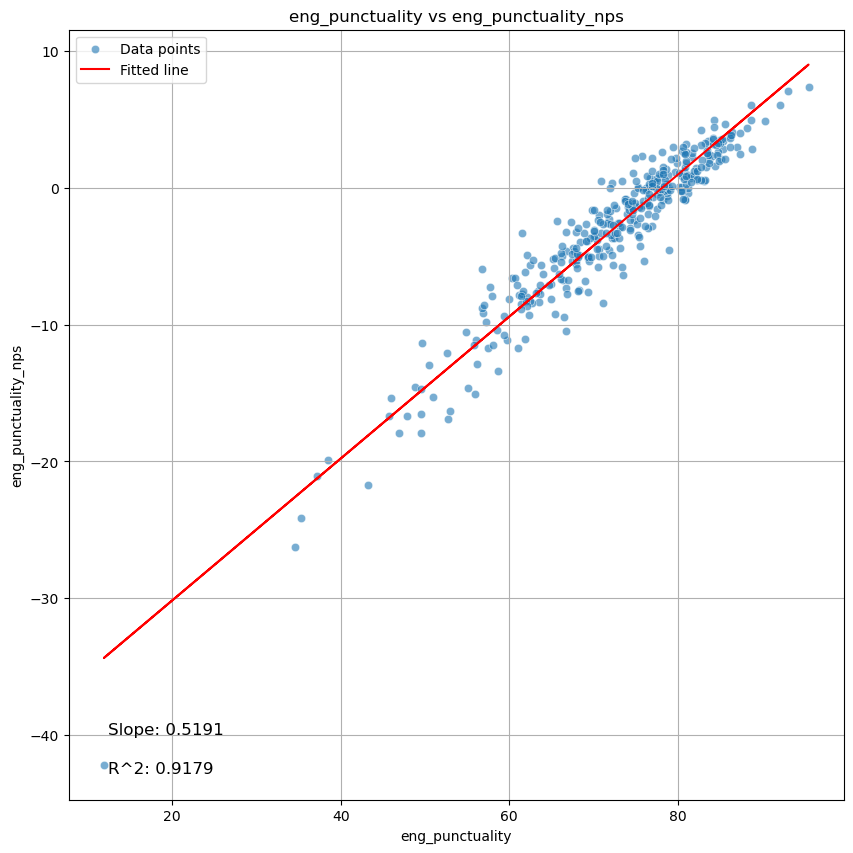

(0.5191194287078554, -40.55840225333831, 0.9178856400517336)

In [90]:
scatter_plot_with_regression(daily_hist_df, 'eng_punctuality', 'eng_punctuality_nps')

In [93]:
scatter_plot_with_regression(daily_hist_df, 'otp15_takeoff', 'eng_punctuality_nps')

KeyError: ['otp15_takeoff']

In [ ]:
# scatter_plot_with_regression(daily_hist_df, 'pun_100_punctuality', 'pun_100_punctuality_nps')

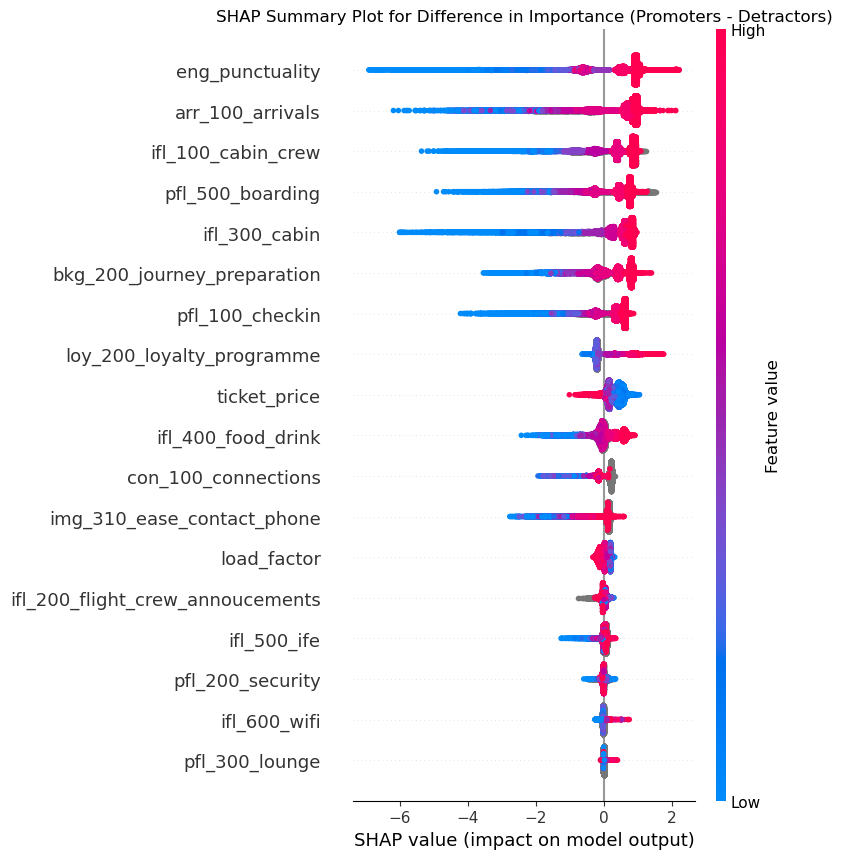

In [88]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Filtra los datos según las condiciones dadas
df = df_nps_tkt.copy()
cabin = 'Economy'
haul = 'SH'
df = df[(df['cabin_in_surveyed_flight'] == cabin) & (df['haul'] == haul) & (df['date_flight_local'] >= '2024-01-01')]

# Calcula los valores SHAP para ambos modelos
shap_explainer_prom = shap.TreeExplainer(model_prom)
shap_values_prom = shap_explainer_prom.shap_values(df[features_dummy])

shap_explainer_det = shap.TreeExplainer(model_det)
shap_values_det = shap_explainer_det.shap_values(df[features_dummy])

# Calcula la diferencia en los valores SHAP
shap_values_diff = shap_values_prom - shap_values_det

# Crear un diccionario para mapear los nombres antiguos de las características a los nuevos
old_feature_names = df[features_dummy].columns
new_feature_names = features_dummy
feature_name_mapping = dict(zip(old_feature_names, new_feature_names))

# Renombrar las características en shap_values_diff
renamed_shap_values_diff = pd.DataFrame(shap_values_diff, columns=[feature_name_mapping[name] for name in old_feature_names])

# Plotear el gráfico de resumen de SHAP con las características renombradas
plt.title('SHAP Summary Plot for Difference in Importance (Promoters - Detractors)')
shap.summary_plot(renamed_shap_values_diff.values, df[features_dummy], feature_names=new_feature_names)



In [ ]:
import shap
import matplotlib.pyplot as plt

df= df_nps_tkt.copy()
cabin = 'Economy'
haul = 'SH'
df = df[(df['cabin_in_surveyed_flight']==cabin)&(df['haul']==haul) & (df['date_flight_local']>='2024-01-01')]

# Assuming model_prom is your trained model
shap_Explainer_promoter = shap.TreeExplainer(model_prom)
shap_values = shap_Explainer_promoter.shap_values(df[features_dummy])

# Create a dictionary to map old feature names to new feature names
old_feature_names = df[features_dummy].columns
new_feature_names = features_dummy

# Create a dictionary to map old names to new names
feature_name_mapping = dict(zip(old_feature_names, new_feature_names))

# Rename the features in the shap_values
renamed_shap_values = pd.DataFrame(shap_values, columns=[feature_name_mapping[name] for name in old_feature_names])

# Plot the SHAP summary plot with renamed features
shap.summary_plot(renamed_shap_values.values, df[features_dummy])


In [ ]:
import shap
import matplotlib.pyplot as plt

# Prepare the dataset for predictions, excluding ID and dates
test_set = df_nps_tkt_imputed.drop(['respondent_id', 'date_flight_local', 'cabin_in_surveyed_flight', 'haul', 'detractor_binary', 'promoter_binary'], axis=1, errors='ignore')
    
shap_Explainer_promoter = shap.LinearExplainer(model_prom, test_set, feature_perturbation="correlation_dependent")

# Assuming model_prom is your trained model
shap_values = shap_Explainer_promoter.shap_values(df_nps_tkt_imputed[features_dummy])

# Create a dictionary to map old feature names to new feature names
old_feature_names = df_nps_tkt[features_dummy].columns
new_feature_names = features_dummy

# Create a dictionary to map old names to new names
feature_name_mapping = dict(zip(old_feature_names, new_feature_names))

# Rename the features in the shap_values
renamed_shap_values = pd.DataFrame(shap_values, columns=[feature_name_mapping[name] for name in old_feature_names])

# Plot the SHAP summary plot with renamed features
shap.summary_plot(renamed_shap_values.values, df_nps_tkt[features_dummy])


In [ ]:
import pickle

# Assuming you have already defined and trained model_prom and model_det as follows:
model_prom = train_results['models']['promoter_binary']
model_det = train_results['models']['detractor_binary']

# Save model_prom to a file
with open('model_prom.pkl', 'wb') as file:
    pickle.dump(model_prom, file)

# Save model_det to a file
with open('model_det.pkl', 'wb') as file:
    pickle.dump(model_det, file)


In [ ]:
df_probability_binary.to_csv('corrected_delay.csv')

In [ ]:
df_probability_binary.columns

In [ ]:


# Lista de años de interés
years_of_interest = [2019, 2022, 2023, 2024]
explanations=[]
features_dummy = ['ticket_price', 'load_factor', 'otp15_takeoff', 'bkg_200_journey_preparation', 'pfl_100_checkin', 
                  'pfl_200_security', 'pfl_300_lounge', 'pfl_500_boarding', 'ifl_300_cabin', 
                  'ifl_200_flight_crew_annoucements', 'ifl_600_wifi', 'ifl_500_ife', 'ifl_400_food_drink', 
                  'ifl_100_cabin_crew', 'arr_100_arrivals', 'con_100_connections', 
                  'loy_200_loyalty_programme', 'img_310_ease_contact_phone']
for year in years_of_interest:
    for month in range(1, 13):
        if year == 2024 and month > 4:
            break
        


        start_date = f"{year}-{month:02d}-01"
        end_date = (pd.to_datetime(start_date) + MonthEnd(1)).strftime('%Y-%m-%d')

#         # Filtrar el DataFrame por las fechas de inicio y fin
#         df_filtered = df_nps_tkt[(df_nps_tkt['date_flight_local'] >= start_date) & (df_nps_tkt['date_flight_local'] < end_date)]

#         # Verificar si df_filtered está vacío
#         if df_filtered.empty:
#             print(f"No hay datos para el rango de fechas desde {start_date} hasta {end_date}.")
#             continue

        explanation, df_probability_binary = predict_and_explain(model_prom, model_det, df_nps_tkt, features_dummy, start_date, end_date)
    
       
    
        # No romper el bucle; solo continuar si 'explanation' es None
        if explanation is not None:
            print(explanation)
            explanations.append(explanation)
            # Guardar cada explicación con un nombre de archivo que refleje el mes y año
            file_name = f'pipeline_output/raw_explanations/explanation_{month}_{year}.pkl'
            with open(file_name, 'wb') as file:
                pickle.dump(explanation, file)
            print(file_name)
            print(pred_nps)
            shap.plots.waterfall(explanation, max_display=20)

In [ ]:
df_hist=pd.read_csv('pipeline_output/historic_predictions (11).csv')

In [ ]:
df_hist

In [ ]:
[df_hist[f'{feat}_nps'].mean()*100 for feat in features_dummy]

In [ ]:
def aggregate_shaps(df,features_dummy, start_date, end_date):

    # 1. Filtrar el DataFrame por el rango de fechas
    df_probability_binary = df[(df['date_flight_local'] >= start_date) & (df['date_flight_local'] < end_date)]
    
    # df_probability_binary.drop(columns=['respondent_id','date_flight_local','model_version','insert_date_ci'])

    # 2. Asumiendo que las funciones de cálculo de SHAP y probabilidad ya están implementadas y ajustadas para usar df_filtered
    # 6. Agregar variables y valores SHAP para crear una explicación general
    # num_vars = ['delay_departure','ticket_price']
    num_vars = ['ticket_price', 'load_factor']
    bin_vars = ['otp15_takeoff']
    # bin_vars = ['otp15_takeoff'] + [col for col in df_nps_tkt.columns if 'country_agg' in col]
    # cat_vars=['segment']
    # bin_vars=[]
    cat_vars=[]
    touchpoints = [feat for feat in features_dummy if feat not in bin_vars + num_vars]
    
    # values_nps_sum = [pd.to_numeric(df_probability_binary[f'{feat}_nps'], errors='coerce').mean()*100 for feat in features_dummy]
    values_nps_sum = [df_probability_binary[f'{feat}_nps'].mean()*100 for feat in features_dummy]
    num_var_scores = [df_probability_binary[num_var].mean() for num_var in num_vars]
    bin_vars_scores = []
    for var in bin_vars:
        if var == 'otp15_takeoff':
            # Para 'otp15_takeoff', calcula el porcentaje de 0s.
            score = (df_probability_binary[df_probability_binary[var] == 0][var].count() / 
                     df_probability_binary[var].count()) * 100
        else:
            # Para cualquier otra variable, calcula el porcentaje de 1s.
            score = (df_probability_binary[df_probability_binary[var] == 1][var].count() / 
                     df_probability_binary[var].count()) * 100
        bin_vars_scores.append(score)
    # Continuación después de calcular bin_vars_scores
    cat_vars_scores = []
    for cat_var in cat_vars:
        cat_vars_scores.append(0)

    satisfaction_scores = [df_probability_binary[df_probability_binary[tp] >= 8][tp].count() / df_probability_binary[tp].count() * 100 for tp in touchpoints]
    shap_data = np.array(num_var_scores + bin_vars_scores + satisfaction_scores)
    base_value_nps_sum = df_probability_binary['base_prob_nps'].mean() * 100
    shap_values = np.array(values_nps_sum)  # Convertimos la lista en un array 2D
    features_names = np.array(features_dummy)
    explainer = shap.Explanation(values=shap_values, 
                                 base_values=base_value_nps_sum, 
                                 data=shap_data, 
                                 feature_names=features_names)
    pred_nps = df_probability_binary['out_prob_nps'].mean()
        
    return explainer, df_probability_binary, pred_nps

# model_prom=train_results['models']['promoter_binary']
# model_det=train_results['models']['detractor_binary']

# Lista de años de interés
years_of_interest = [2019, 2022, 2023, 2024]
explanations=[]
features_dummy = ['ticket_price', 'load_factor', 'otp15_takeoff', 'bkg_200_journey_preparation', 'pfl_100_checkin', 
                  'pfl_200_security', 'pfl_300_lounge', 'pfl_500_boarding', 'ifl_300_cabin', 
                  'ifl_200_flight_crew_annoucements', 'ifl_600_wifi', 'ifl_500_ife', 'ifl_400_food_drink', 
                  'ifl_100_cabin_crew', 'arr_100_arrivals', 'con_100_connections', 
                  'loy_200_loyalty_programme', 'img_310_ease_contact_phone']
for year in years_of_interest:
    for month in range(1, 13):
        if year == 2024 and month > 4:
            break
        


        start_date = f"{year}-{month:02d}-01"
        end_date = (pd.to_datetime(start_date) + MonthEnd(1)).strftime('%Y-%m-%d')

#         # Filtrar el DataFrame por las fechas de inicio y fin
#         df_filtered = df_nps_tkt[(df_nps_tkt['date_flight_local'] >= start_date) & (df_nps_tkt['date_flight_local'] < end_date)]

#         # Verificar si df_filtered está vacío
#         if df_filtered.empty:
#             print(f"No hay datos para el rango de fechas desde {start_date} hasta {end_date}.")
#             continue

        explanation, df_probability_binary, pred_nps = aggregate_shaps(df_hist,features_dummy, start_date, end_date)
    
       
    
        # No romper el bucle; solo continuar si 'explanation' es None
        if explanation is not None:
            print(explanation)
            explanations.append(explanation)
            # Guardar cada explicación con un nombre de archivo que refleje el mes y año
            file_name = f'pipeline_output/raw_explanations/explanation_{month}_{year}.pkl'
            with open(file_name, 'wb') as file:
                pickle.dump(explanation, file)
            print(file_name)
            print(pred_nps)
            shap.plots.waterfall(explanation, max_display=20)


In [ ]:
def compare_monthly_explanations(start_year, start_month, end_year, end_month):
    """
    Compara automáticamente cada mes con el mismo mes del año anterior o con 2019 si el año es 2022,
    desde una fecha de inicio dada, y devuelve un diccionario con los objetos de explicación.

    Args:
    - start_year: Año de inicio para las comparaciones.
    - start_month: Mes de inicio para las comparaciones.
    - end_year: Año final para las comparaciones.
    - end_month: Mes final para las comparaciones.

    Returns:
    - Un diccionario con las comparaciones de objetos de explicación. Las claves son las fechas de comparación.
    """
    uplifting_explanations_dict = {}

    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            if year == start_year and month < start_month:
                continue
            if year == end_year and month > end_month:
                break

            # Ajuste para el año 2022: comparar con 2019
            if year == 2022:
                previous_year_explanation = load_explanation(2019, month)
            else:
                previous_year_explanation = load_explanation(year - 1, month)

            current_explanation = load_explanation(year, month)

            if current_explanation is not None and previous_year_explanation is not None:
                uplifting_explanation = create_uplifting_explanation(previous_year_explanation,current_explanation)
                # Ajuste en la clave para reflejar la comparación especial del año 2022 con 2019
                if year == 2022:
                    date_key = f"2019-{month:02d} to {year}-{month:02d}"
                else:
                    date_key = f"{year-1}-{month:02d} to {year}-{month:02d}"
                uplifting_explanations_dict[date_key] = uplifting_explanation
            print(date_key)  
            shap.plots.waterfall(uplifting_explanations_dict[date_key], max_display=20)

    return uplifting_explanations_dict

# Ejemplo de uso
uplifting_explanations_dict = compare_monthly_explanations(2023, 3, 2024, 3)

In [ ]:
os.getcwd()

In [ ]:
import os

# Define la ruta al directorio deseado
path = '/root/NPS forecasting model/nps_client_model/Explainability_model_pipeline/develop'

# Cambia el directorio de trabajo
os.chdir(path)

# Verifica el cambio de directorio
print("Directorio actual:", os.getcwd())


In [ ]:
import pickle
years_of_interest = [2022, 2023]
explanation = {}
for year in years_of_interest:
    for month in range(1, 13):
        if year == 2023 and month > 2:
            break
        file_name = f'v8_lf_dem_reconstructed/compared_explanations/explanation_{year}-0{month} to {year+1}-0{month}.pkl'
        try:
            with open(file_name, 'rb') as file:
                explanation[f'{month}_{year}'] = pickle.load(file)
            print(f"Loaded {file_name}")
            shap.plots.waterfall(explanation[f'{month}_{year}'], max_display=20)
        except FileNotFoundError:
            print(f"File {file_name} not found.")


# Comparisons

In [ ]:
def create_uplifting_explanation(explanation2, explanation1):
    """
    Create a new Explanation object representing the uplifting between two Explanation objects.

    Parameters:
        - explanation1: The first shap.Explanation object.
        - explanation2: The second shap.Explanation object.

    Returns:
        - A new shap.Explanation object representing the uplifting.
    """
    # Calculate the difference in values, base_values, and data
    diff_values = explanation1.values - explanation2.values
    
    diff_base_values = explanation2.base_values + sum(explanation2.values)
    print(sum(explanation2.values))
    diff_data = explanation1.data - explanation2.data

    # Create a new Explanation object with the difference values
    diff_explanation = shap.Explanation(values=diff_values, base_values=diff_base_values, data=diff_data,
                                        feature_names=explanation1.feature_names)

    return diff_explanation

In [ ]:
def adjust_shap_values(shap_explanation, monotonic_constraints):
    # Step 1: Compute total SHAP contribution
    total_shap_contribution = np.sum(shap_explanation.values)

    # Step 2: Handle zero .data cases
    non_zero_data_indices = [i for i, data in enumerate(shap_explanation.data) if data != 0]
    for i, data in enumerate(shap_explanation.data):
        if data == 0:
            shap_explanation.values[i] = 0

    # Step 3: Adjust values based on monotonic constraints
    for i in non_zero_data_indices:
        feature = shap_explanation.feature_names[i]
        constraint = monotonic_constraints.get(feature, 0)
        if constraint == 1 and np.sign(shap_explanation.data[i]) == np.sign(shap_explanation.values[i]):
            shap_explanation.values[i] = -shap_explanation.values[i]
        elif constraint == -1 and np.sign(shap_explanation.data[i]) != np.sign(shap_explanation.values[i]):
            shap_explanation.values[i] = -shap_explanation.values[i]

    # Step 4: Sign-preserving normalization for non-zero .data variables
    current_total_non_zero = sum(shap_explanation.values[i] for i in non_zero_data_indices)
    if current_total_non_zero != 0:
        normalization_factor = total_shap_contribution / current_total_non_zero
        for i in non_zero_data_indices:
            shap_explanation.values[i] *= normalization_factor

    # Step 5: Return the modified SHAP explanation object
    return shap_explanation

In [ ]:
def load_explanation(year, month):
    """Cargar un objeto de explicación desde un archivo."""
    file_name = f'pipeline_output/raw_explanations/explanation_{month}_{year}.pkl'
    try:
        with open(file_name, 'rb') as file:
            explanation = pickle.load(file)
        return explanation
    except FileNotFoundError:
        print(f"No explanation file found for {month}/{year}.")
        return None

# Ejemplo de uso: Comparar febrero de 2023 con febrero de 2022
explanation_2022_02 = load_explanation(2022, 1)
explanation_2023_02 = load_explanation(2023, 1)

if explanation_2022_02 is not None and explanation_2023_02 is not None:
    print('2022 vs 2023: Januery')
    uplifting_explanation = create_uplifting_explanation(explanation_2023_02, explanation_2022_02)
    # Procesar o visualizar el uplifting_explanation según sea necesario
    shap.plots.waterfall(uplifting_explanation, max_display=30)



In [ ]:
uplifting_explanation

In [ ]:
def compare_monthly_explanations(start_year, start_month, end_year, end_month):
    """
    Compara automáticamente cada mes con el mismo mes del año anterior o con 2019 si el año es 2022,
    desde una fecha de inicio dada, y devuelve un diccionario con los objetos de explicación.

    Args:
    - start_year: Año de inicio para las comparaciones.
    - start_month: Mes de inicio para las comparaciones.
    - end_year: Año final para las comparaciones.
    - end_month: Mes final para las comparaciones.

    Returns:
    - Un diccionario con las comparaciones de objetos de explicación. Las claves son las fechas de comparación.
    """
    uplifting_explanations_dict = {}

    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            if year == start_year and month < start_month:
                continue
            if year == end_year and month > end_month:
                break

            # Ajuste para el año 2022: comparar con 2019
            if year == 2022:
                previous_year_explanation = load_explanation(2019, month)
            else:
                previous_year_explanation = load_explanation(year - 1, month)

            current_explanation = load_explanation(year, month)

            if current_explanation is not None and previous_year_explanation is not None:
                uplifting_explanation = create_uplifting_explanation(previous_year_explanation,current_explanation)
                # Ajuste en la clave para reflejar la comparación especial del año 2022 con 2019
                if year == 2022:
                    date_key = f"2019-{month:02d} to {year}-{month:02d}"
                else:
                    date_key = f"{year-1}-{month:02d} to {year}-{month:02d}"
                uplifting_explanations_dict[date_key] = uplifting_explanation

    return uplifting_explanations_dict

# Ejemplo de uso
uplifting_explanations_dict = compare_monthly_explanations(2023, 1, 2024, 1)




In [ ]:
# Initialize a dictionary to store the monotonic parameters
monotonic_params = {}
# Loop through the features for this dataframe
for feature in uplifting_explanation.feature_names:
    if "load_factor" in feature or "price" in feature or "delay" in feature:
        monotonic_params[f'{feature}']=-1  # Assign -1 to load_factor and mean_price
    elif feature in touchpoints + ['otp15_takeoff']:
        monotonic_params[f'{feature}']=1 # Assign 0 to other features for now
print(monotonic_params)

adjusted_explanations = {}
for date, explanation in uplifting_explanations_dict.items():
    print(date)
    adjusted_explanations[date] = adjust_shap_values(explanation, monotonic_params)
    shap.plots.waterfall(explanation, max_display=30)
    # Guardar cada explicación con un nombre de archivo que refleje el mes y año
    file_name = f'vnationality_lf_tprec_te/compared_explanations/explanation_{date}.pkl'
    with open(file_name, 'wb') as file:
        pickle.dump(adjusted_explanations[date], file)
    

# MAE

In [ ]:
uplifting_januery_explanations_dict

# Explanations corrrected to meet true values

In [ ]:
nps_monthly_df

In [ ]:

def adjust_shap_values(original_shap_values, expected_value, real_value):
    """
    Ajusta los valores SHAP utilizando un factor de normalización para que la suma del valor base y
    los valores SHAP ajustados sea igual al valor NPS real.
    
    Args:
    - original_shap_values: Array de valores SHAP originales para las características.
    - expected_value: Valor base del modelo SHAP (el valor predicho sin contribuciones de características).
    - real_value: Valor NPS real observado.
    
    Returns:
    - Array de valores SHAP ajustados.
    """
    # Calcula el valor NPS predicho por el modelo (valor base + suma de SHAPs)
    predicted_nps = expected_value + np.sum(original_shap_values)
    
    # Calcula el total actual de los valores SHAP
    total_shap_sum = np.sum(original_shap_values)
    
    # Determina la nueva suma total de los valores SHAP necesaria para que la suma de esta con el valor base sea igual al valor NPS real
    required_shap_sum = real_value - expected_value
    
    # Calcula el factor de normalización
    if total_shap_sum != 0:  # Prevenir división por cero
        normalization_factor = required_shap_sum / total_shap_sum
    else:
        normalization_factor = 0
    
    # Ajusta los valores SHAP utilizando el factor de normalización
    adjusted_shap_values = original_shap_values * normalization_factor
    
    return adjusted_shap_values

explanations_dict = {}

for index, row in nps_monthly_df.iterrows():
    year_month_key = f"{row['date_flight_local'].year}-{row['date_flight_local'].month:02d}"
    real_value = row['NPS']

    file_name = f'vnationality_lf_tprec_te/raw_explanations/explanation_{row["date_flight_local"].month}_{row["date_flight_local"].year}.pkl'
    try:
        with open(file_name, 'rb') as file:
            original_explanation = pickle.load(file)
            
            # Ajusta los valores SHAP
            adjusted_shap_values = adjust_shap_values(original_explanation.values, original_explanation.base_values, real_value)
            
            # Crea el nuevo objeto de explicación SHAP ajustado
            adjusted_explanation = shap.Explanation(
                values=adjusted_shap_values,
                base_values=original_explanation.base_values,
                data=original_explanation.data,
                feature_names=original_explanation.feature_names
            )
            
            # Verifica si el valor NPS ajustado coincide con el valor NPS real
            adjusted_nps = adjusted_explanation.base_values + np.sum(adjusted_shap_values)
            
            if np.isclose(adjusted_nps, real_value, atol=1e-6):
                # Guarda en el diccionario
                explanations_dict[year_month_key] = {
                    "original_explanation": original_explanation,
                    "adjusted_shap_values": adjusted_explanation,
                    "error": real_value - original_explanation.base_values - np.sum(original_explanation.values)
                }
            else:
                print(f"Error en la coincidencia de NPS para {year_month_key}: ajustado {adjusted_nps}, predicted {original_explanation.base_values + np.sum(original_explanation.values)}, real {real_value}, base: {original_explanation.base_values}")
    except FileNotFoundError:
        print(f"Archivo no encontrado: {file_name}")


In [ ]:
# Ejemplo de cómo acceder a la información ajustada
# Suponiendo que queremos ver la explicación ajustada para Marzo 2022
if '2022-03' in explanations_dict:
    print(explanations_dict['2022-03'])
else:
    print("No se encontró la explicación ajustada para Marzo 2022.")

In [ ]:
def plot_waterfall_comparison(original_explanation, adjusted_explanation, error):
    # Preparar datos para el gráfico
    features = original_explanation.feature_names
    original_values = np.sum(original_explanation.values, axis=0)  # Suma de valores SHAP por característica
    adjusted_values = np.sum(adjusted_explanation.values, axis=0)  # Asegúrate de acceder a .values del objeto Explanation
    base_value = original_explanation.base_values

    # Crear arrays para el gráfico
    labels = np.concatenate([features, ['Base Value', 'Error']])
    contributions = np.concatenate([original_values - adjusted_values, [base_value, error]])
    starts = np.zeros_like(contributions)
    starts[1:] = np.cumsum(contributions[:-1])
    colors = ['skyblue'] * len(features) + ['salmon', 'gray']

    # Crear gráfico de cascada
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(labels, contributions, bottom=starts, color=colors, edgecolor='gray')
    ax.set_title('SHAP Values: Original vs Adjusted')
    ax.set_ylabel('Contribution to NPS')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Asegúrate de pasar los objetos de explicación correctos y el error a la función.
if '2022-03' in explanations_dict:
    original_explanation = explanations_dict['2022-03']["original_explanation"]
    adjusted_explanation = explanations_dict['2022-03']["adjusted_shap_values"]
    error = explanations_dict['2022-03']["error"]
    plot_waterfall_comparison(original_explanation, adjusted_explanation, error)
else:
    print("Datos no disponibles para el mes seleccionado.")


#### 